In [373]:
import pandas as pd
import numpy as np
import glob
import os
from matplotlib import pyplot
import seaborn as sbn
import seaborn as sbn
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

In [374]:
pd. set_option("display.max_columns", None) 

In [375]:
df = pd.read_csv('./ios-fitness-and-medical-cleaned-data.csv')

#### Feature Engineering

In [376]:
def is_english_supported(language):
    return language.find('English') >=0

In [377]:
def determine_if_app_is_free_or_not(price):
    if (price > 0):
        return 'PAID'
    return 'FREE'

In [378]:
def grade_app_with_rating(app_rating):
    if ((app_rating >=0) and (app_rating <2.5)):
        return 'BAD'
    if ((app_rating >=2.5) and (app_rating <3.0)):
        return 'FAIR'
    if ((app_rating >=3.0) and (app_rating <4.0)):
        return 'GOOD'
    if ((app_rating >=4.0) and (app_rating <4.5)):
        return 'VERY GOOD'
    if (app_rating >=4.5):
        return 'EXCELLENT'

- 1-49 : FAIR
- 50 - 99 : GOOD
- 100 - 500 : VERY GOOD
- 501+ : EXCELLENT

In [379]:
def grade_app_with_rating2(app_rating, rating_count):
    if ((app_rating >=0) and (app_rating <2.5)):
        return 'BAD'
    if ((app_rating >=2.5) and (app_rating <3.0)):
        return 'FAIR'
    if ((app_rating >=3.0) and (app_rating <4.0)):
        if rating_count < 50:
            return 'FAIR'
        return 'GOOD'
    if ((app_rating >=4.0) and (app_rating <4.5)):
        if rating_count < 50:
            return 'FAIR'
        elif rating_count >=50 and rating_count <100:
            return 'GOOD' 
        else:
            return 'VERY GOOD'
    if (app_rating >=4.5):
        if rating_count < 50:
            return 'FAIR'
        elif rating_count >=50 and rating_count <100:
            return 'GOOD'
        elif rating_count >=100 and rating_count < 500:
            return 'VERY GOOD'
        else:
            return 'EXCELLENT'

In [380]:
def create_rating_count_range(rating_count):
    if (rating_count >=1 and rating_count<5):
        return '1+'
    if (rating_count >=5 and rating_count<10):
        return '5+'
    if (rating_count >=10 and rating_count<50):
        return '10+'
    if (rating_count >=50 and rating_count<100):
        return '50+'
    if (rating_count >=100 and rating_count<500):
        return '100+'
    if (rating_count >=500 and rating_count<1000):
        return '500+'
    if (rating_count >=1000 and rating_count<5000):
        return '1,000+'
    if (rating_count >=5000 and rating_count<10000):
        return '5,000+'
    if (rating_count >=10000 and rating_count<50000):
        return '10,000+'
    if (rating_count >=50000 and rating_count<100000):
        return '50,000+'
    if (rating_count >=100000 and rating_count<500000):
        return '100,000+'
    if (rating_count >=500000 and rating_count<1000000):
        return '500,000+'
    if (rating_count >=1000000 and rating_count<5000000):
        return '1,000,000+'
    if (rating_count >=5000000 and rating_count<10000000):
        return '5,000,000+'
    if (rating_count >=10000000 and rating_count<50000000):
        return '10,000,000+'
    if (rating_count >=50000000 and rating_count<100000000):
        return '50,000,000+'
    return 0

In [381]:
def create_price_category(rating_count):
    if (rating_count >0.0 and rating_count<1.0):
        return '0+'
    if (rating_count >=1 and rating_count<5):
        return '1+'
    if (rating_count >=5 and rating_count<10):
        return '5+'
    if (rating_count >=10 and rating_count<50):
        return '10+'
    if (rating_count >=50 and rating_count<100):
        return '50+'
    if (rating_count >=100 and rating_count<500):
        return '100+'
    if (rating_count >=500 and rating_count<1000):
        return '500+'
    return None

In [382]:
def is_app_available_in_multiple_languages(languages):
    return len(languages.split(',')) > 1

In [383]:
def is_privacy_data_collected(privacy_data):
    if pd.notna(privacy_data):
        return True
    return False

In [384]:
def is_app_ever_updated(version_count):
    return version_count > 1

In [385]:
def is_app_updated_in_2022(last_updated_date, released_date, versions_count):
    if (versions_count < 2):
        return False
    if (last_updated_date == released_date):
        return False
    if '2022' in last_updated_date:
        return True
    return False

In [386]:
def perform_feature_engineering(df):
    lang_na_indexes = df[df['Languages'].isna()].index
    df.loc[lang_na_indexes, 'Languages'] = 'Not Specified'
    df['is_english_supported'] = df['Languages'].apply(is_english_supported)
    df['Service Type'] = df['Price'].apply(determine_if_app_is_free_or_not)
#     df['App Grade'] = df['Average Rating'].apply(grade_app_with_rating)
    df['Rating Count Range'] = df['Rating Count'].apply(create_rating_count_range)
    df['is_available_in_multiple_langs'] = df['Languages'].apply(is_app_available_in_multiple_languages)
    df['is_privacy_data_collected'] = df['Privacy Data'].apply(is_privacy_data_collected)
    df['is_app_ever_updated'] = df['Number of Versions'].apply(is_app_ever_updated)
    df['Price Category'] = df['Price'].apply(create_price_category)
    for index in df.index:
        last_updated_date = df.at[index, 'Last Version Date']
        released_date = df.at[index, 'First Version Date']
        version = df.at[index, 'Number of Versions']
        rating_count = df.at[index, 'Rating Count']
        average_rating = df.at[index, 'Average Rating']
        df.at[index, 'is_updated_this_year'] = is_app_updated_in_2022(last_updated_date, released_date, version)
        df.at[index, 'App Grade'] = grade_app_with_rating2(average_rating, rating_count)

In [387]:
perform_feature_engineering(df)

In [388]:
df[:5]

,Unnamed: 0,App Name,Size,Age Rating,Languages,Price,InApp Purchase,Average Rating,Rating Count,Privacy Data,App Link,Number of Versions,Last Version Date,First Version Date,App Type,is_english_supported,Service Type,Rating Count Range,is_available_in_multiple_langs,is_privacy_data_collected,is_app_ever_updated,Price Category,is_updated_this_year,App Grade
0,0,H and W Drug Store,21.5 MB,12+,"English, Spanish",0.00,False,4.0,4,NaN,https://apps.apple.com/us/app/h-and-w-drug-sto...,1,NaN,NaN,MEDICAL,True,FREE,1+,True,False,False,None,False,FAIR
1,1,H&P-card™,10.1 MB,17+,"English, Spanish",2.99,False,1.0,1,NaN,https://apps.apple.com/us/app/h-p-card/id56971...,5,"Sep 28, 2020","Oct 20, 2012",MEDICAL,True,PAID,1+,True,False,True,1+,False,BAD
2,2,H-Book – osobní zdravotní záznamy,47.1 MB,12+,"English, Czech",0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-book-osobn%C3%...,21,"Jun 28, 2017","Jun 5, 2013",MEDICAL,True,FREE,0,True,False,True,None,False,BAD
3,3,H-FACT,4.1 MB,12+,English,0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-fact/id1568969345,5,"Nov 24, 2021","Jul 5, 2021",MEDICAL,True,FREE,0,False,False,True,None,False,BAD
4,4,H-Module,27.6 MB,17+,Not Specified,0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-module/id15728...,2,"Jun 26, 2021","Jun 22, 2021",MEDICAL,False,FREE,0,False,False,True,None,False,BAD


In [389]:
len(df[df['Rating Count'] == 0])

49886

In [390]:
df['App Type'].value_counts()

HEALTH AND FITNESS    61598
MEDICAL               32381
Name: App Type, dtype: int64

In [391]:
df['is_app_ever_updated'].value_counts()

True     79821
False    14158
Name: is_app_ever_updated, dtype: int64

In [392]:
df['is_updated_this_year'].value_counts()

False    67490
True     26489
Name: is_updated_this_year, dtype: int64

#### VISUALIZATION

In [393]:
rating_count_range_order = [0, '1+', '5+', '10+', '50+', '100+', '500+', '1,000+', '5,000+', '10,000+', '50,000+', 
                            '100,000+', '500,000+', '1,000,000+']

In [394]:
price_range_order = ['0+', '1+', '5+', '10+', '50+', '100+', '500+']

In [395]:
app_grade_order = ['BAD', 'FAIR', 'GOOD', 'VERY GOOD', 'EXCELLENT']

In [396]:
df['Rating Count Range'].value_counts()

0             49886
1+            22501
10+            8053
5+             6362
100+           2757
50+            1889
1,000+         1017
500+            699
10,000+         357
5,000+          288
50,000+          84
100,000+         72
500,000+         11
1,000,000+        3
Name: Rating Count Range, dtype: int64

In [397]:
def draw_histogram(data, x_axis_title, height=5, aspect=1.6):
    sbn.displot(data, color = 'darkblue', kind='hist', height=5, aspect=1.6)
    pyplot.xlabel(x_axis_title)
    pyplot.ylabel('Density')

In [398]:
def draw_count_plot(data, x_column, x_label, y_label, fig_size=(8,6), order=None, hue=None):
    sbn.set(rc = {'figure.figsize':fig_size})
    sbn.countplot(data=data, x=x_column, order=order, color='#1C8BAD', hue=hue )
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='large')
    pyplot.show()

In [530]:
def draw_count_plot_with_annot(data, x_column, x_label, y_label, fig_size=(8,6),annotCount=False, order=None, 
                               hue=None, palette=None):
    sbn.set(rc = {'figure.figsize':fig_size})
    sbndataplot = sbn.countplot(data=data, x=x_column, order=order, color='#1C8BAD', hue=hue, palette=palette)
    for p in sbndataplot.patches:
        if annotCount == True:
            height = p.get_height()
            if (pd.isna(height) == True):
                height = 0
            else:
                height = int(height)
            sbndataplot.annotate(height, 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
        else:
            sbndataplot.annotate(format(p.get_height()/len(data)*100, '.2f')+'%', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='large')
    pyplot.tight_layout(rect=(0, 0, 1, 1.4))
    pyplot.show()

In [399]:
def set_plot_labels(x_label, y_label, font_size):
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize=font_size)

#### Price influence

In [400]:
df['Price'].value_counts()

0.00      87031
0.99       1575
1.99       1259
2.99        990
4.99        701
          ...  
499.99        1
119.99        1
38.99         1
46.99         1
47.99         1
Name: Price, Length: 80, dtype: int64

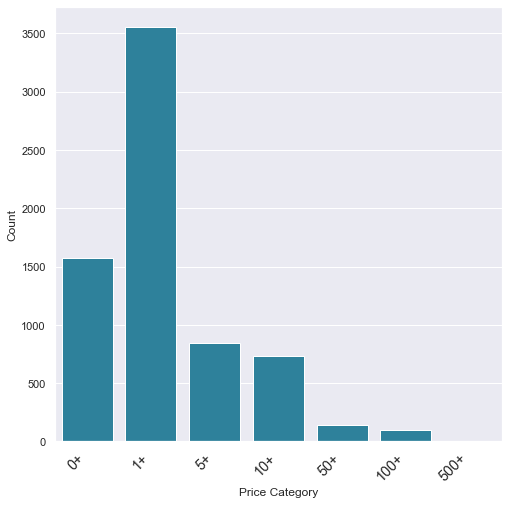

In [401]:
draw_count_plot(df, 'Price Category', 'Price Category', 'Count', fig_size=(8,8), 
               order=price_range_order)

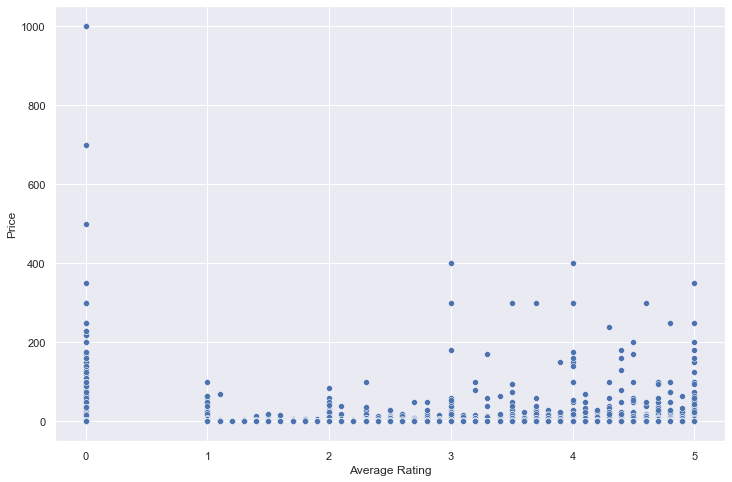

In [402]:
sbn.scatterplot(data=df, y='Price', x='Average Rating')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

In [403]:
df['Price Category'].value_counts()

1+      3553
0+      1575
5+       843
10+      735
50+      143
100+      95
500+       4
Name: Price Category, dtype: int64

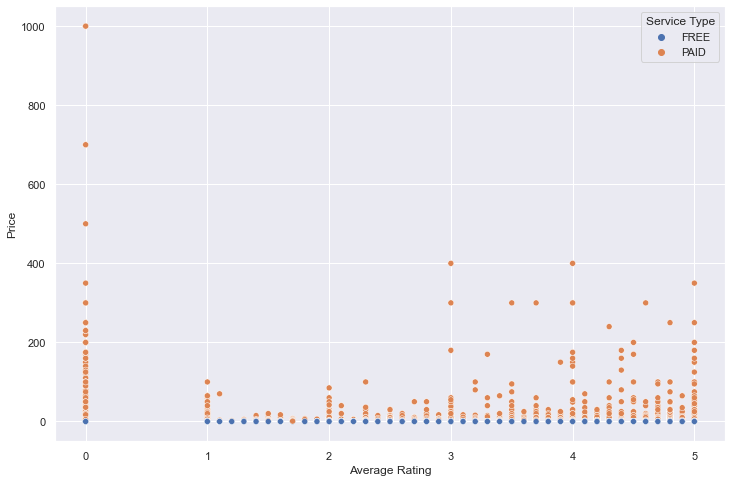

In [404]:
sbn.scatterplot(data=df, y='Price', x='Average Rating', hue='Service Type', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

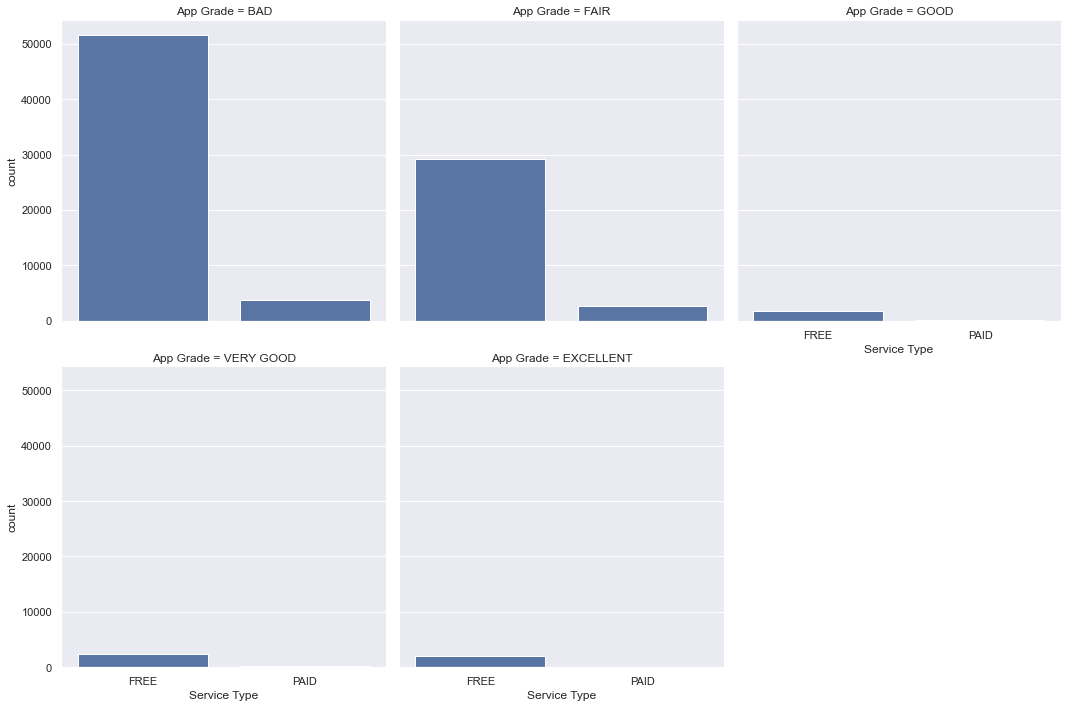

In [405]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=3, height=5, aspect=1.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Service Type", order=['FREE', 'PAID'])

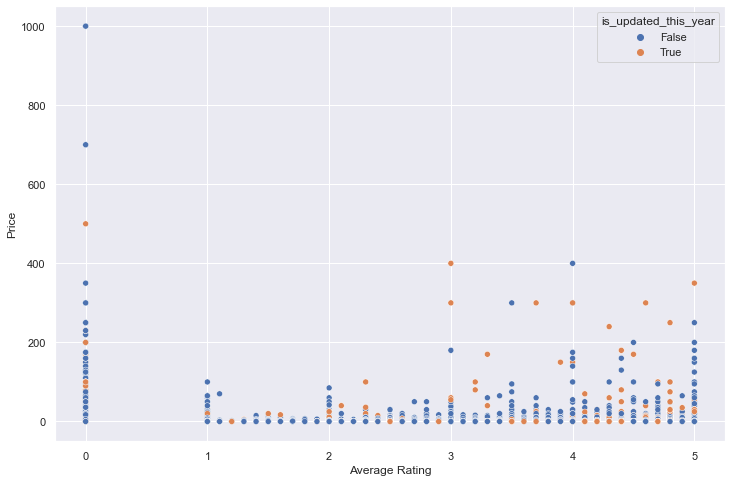

In [406]:
sbn.scatterplot(data=df, x='Average Rating', y='Price', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

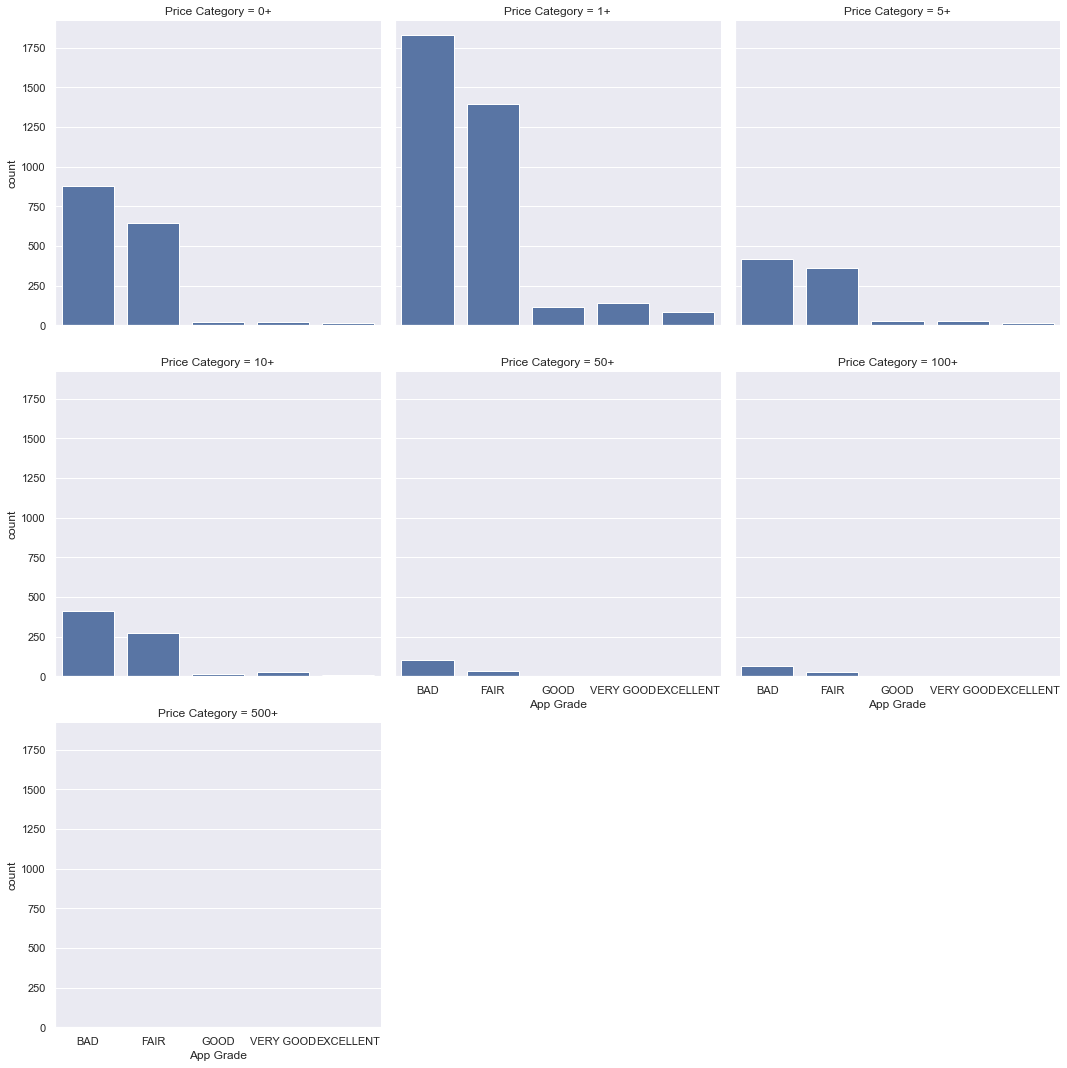

In [407]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Price Category", col_wrap=3, height=5, aspect=1.0,
                                        col_order=price_range_order)
eng_supp_app_grade_plot.map(sbn.countplot, "App Grade", order=app_grade_order)

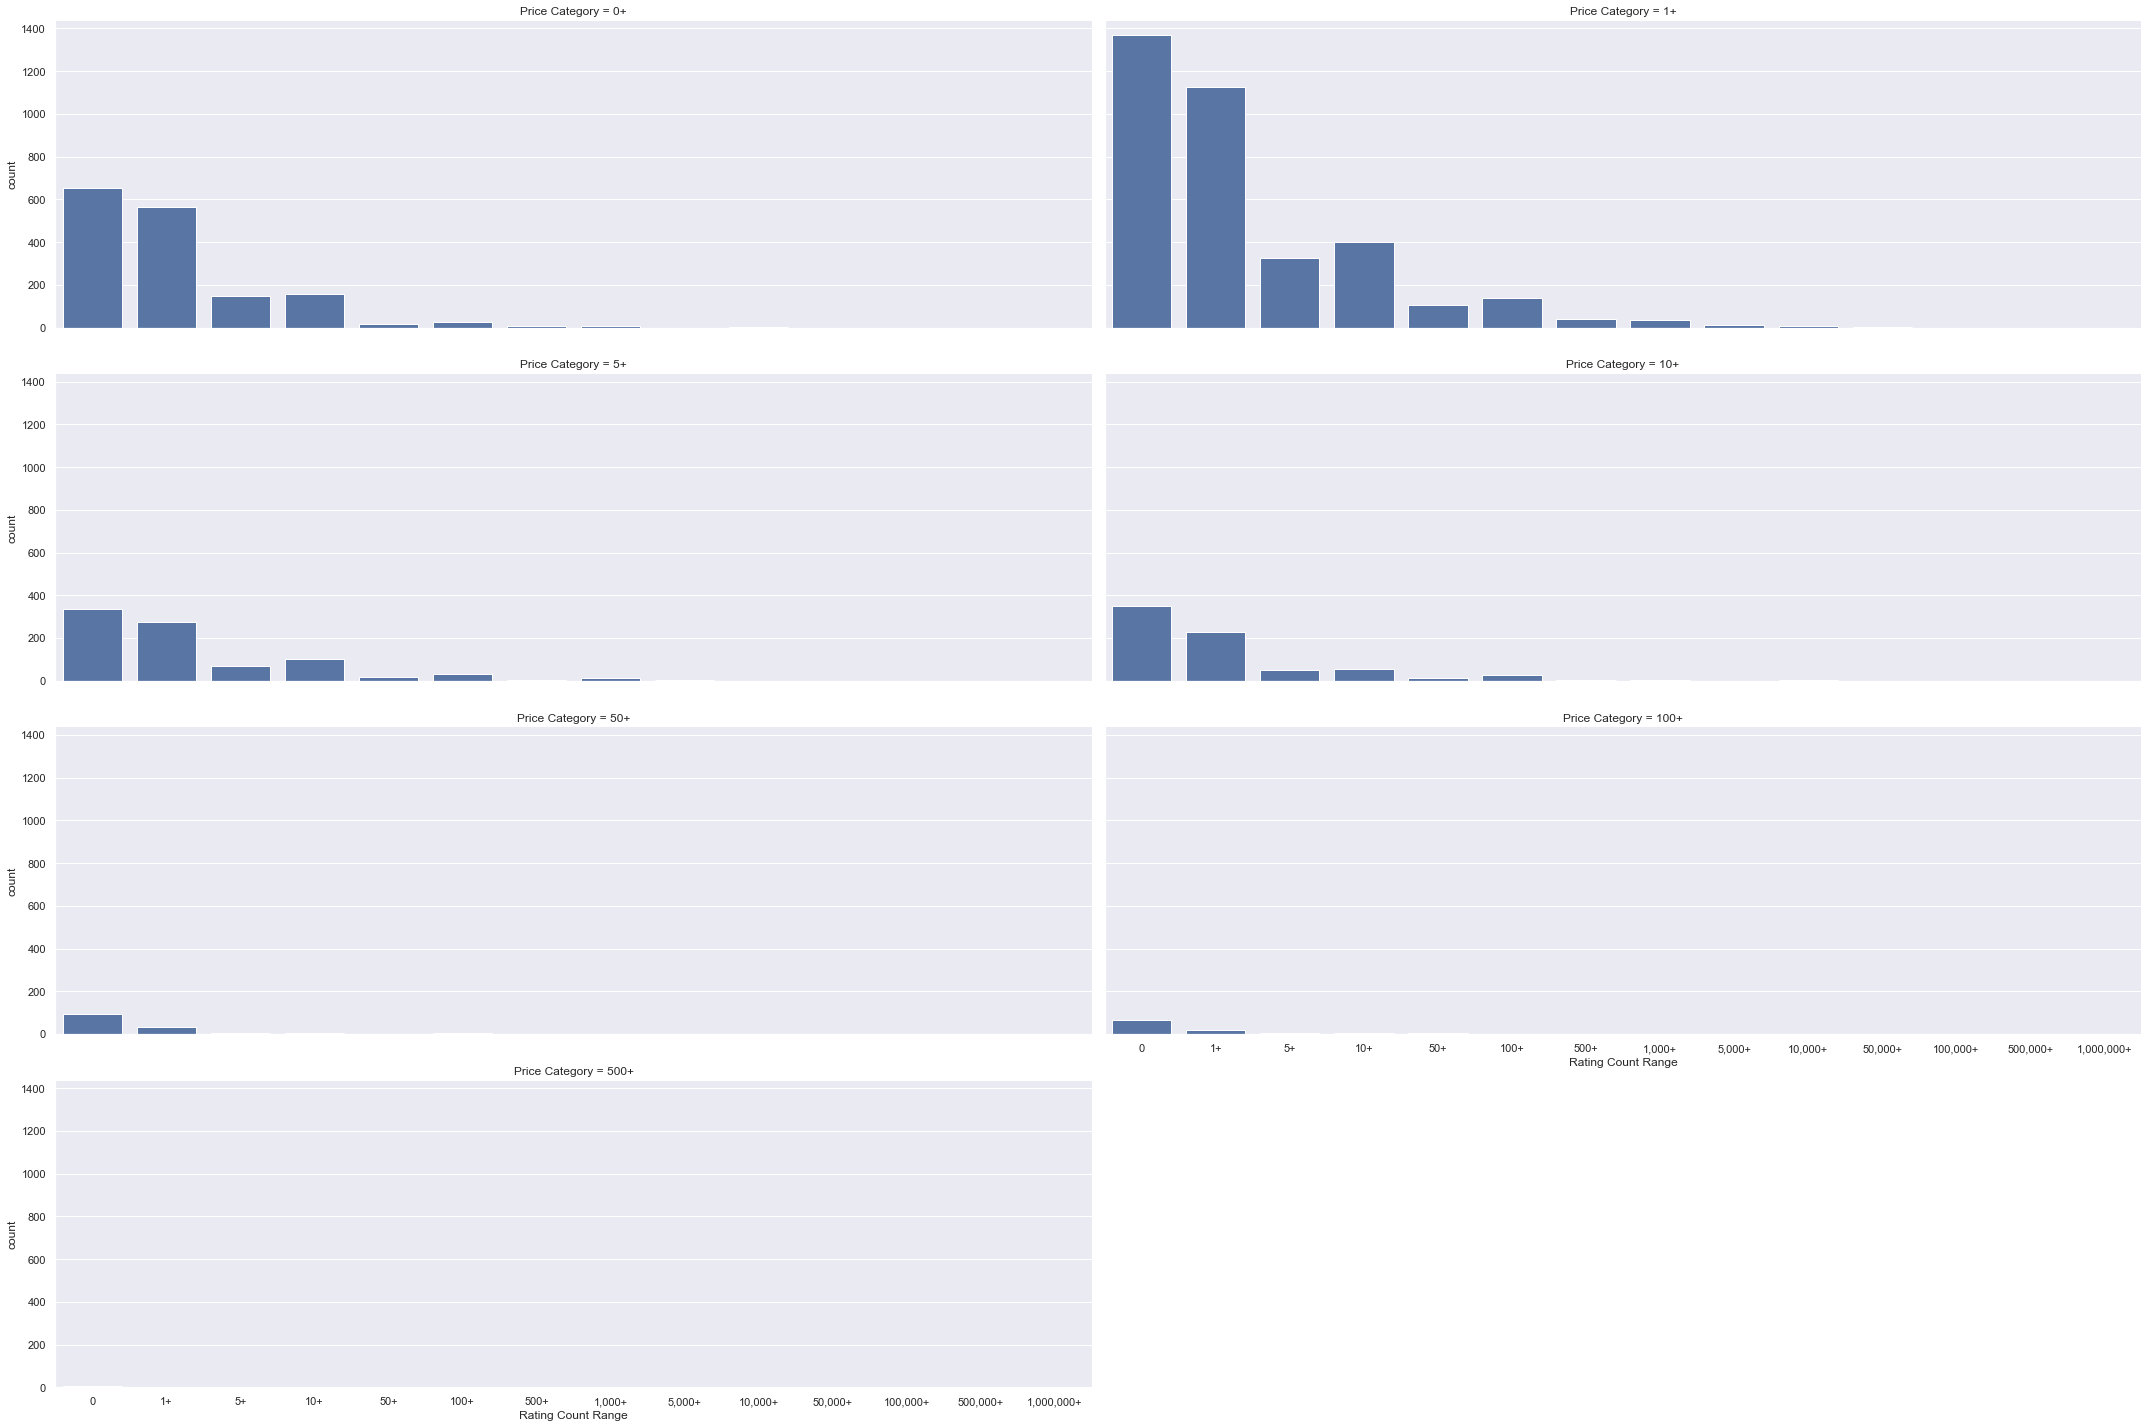

In [408]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Price Category", col_wrap=2, height=5, aspect=3.0,
                                        col_order=price_range_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


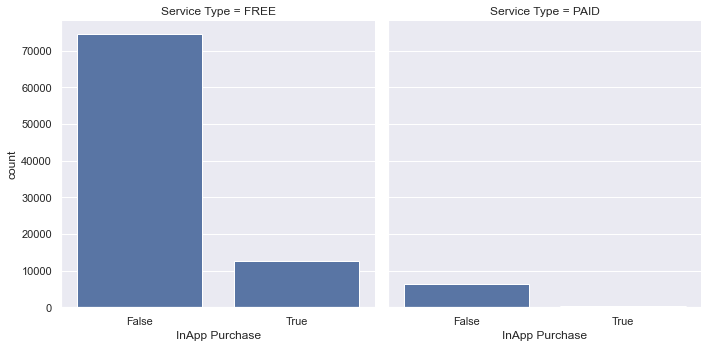

In [409]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Service Type", col_wrap=2, height=5, aspect=1.0)
eng_supp_app_grade_plot.map(sbn.countplot, "InApp Purchase")

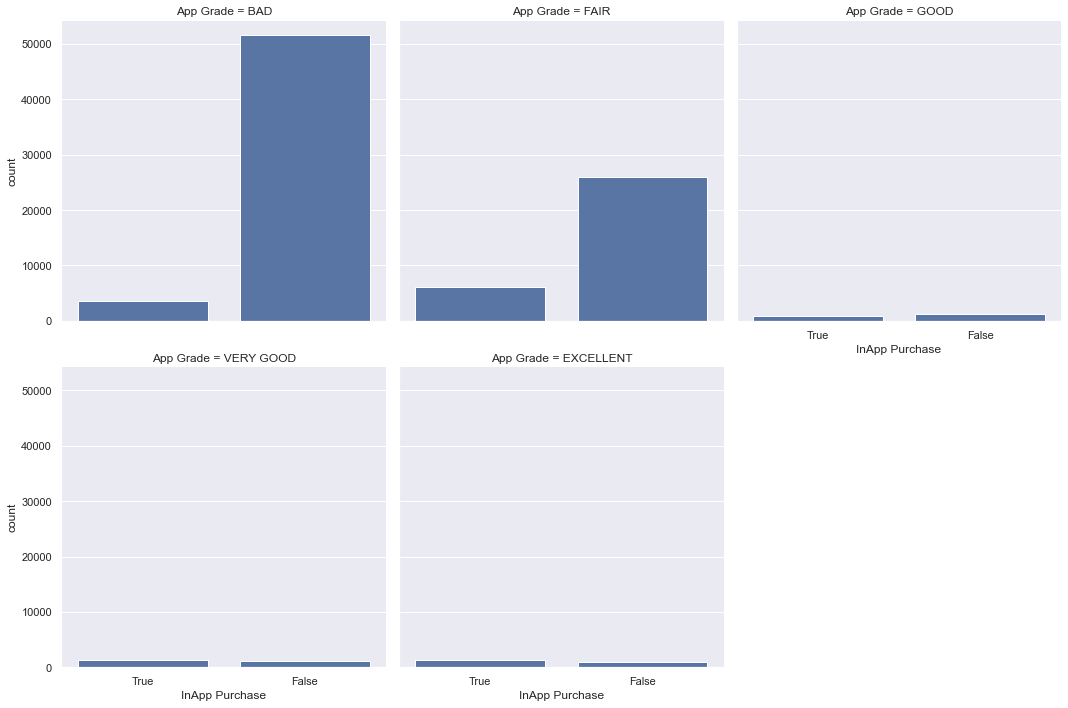

In [410]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=3, height=5, aspect=1.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "InApp Purchase", order=[True, False])

#### Application Rating effect on the app?

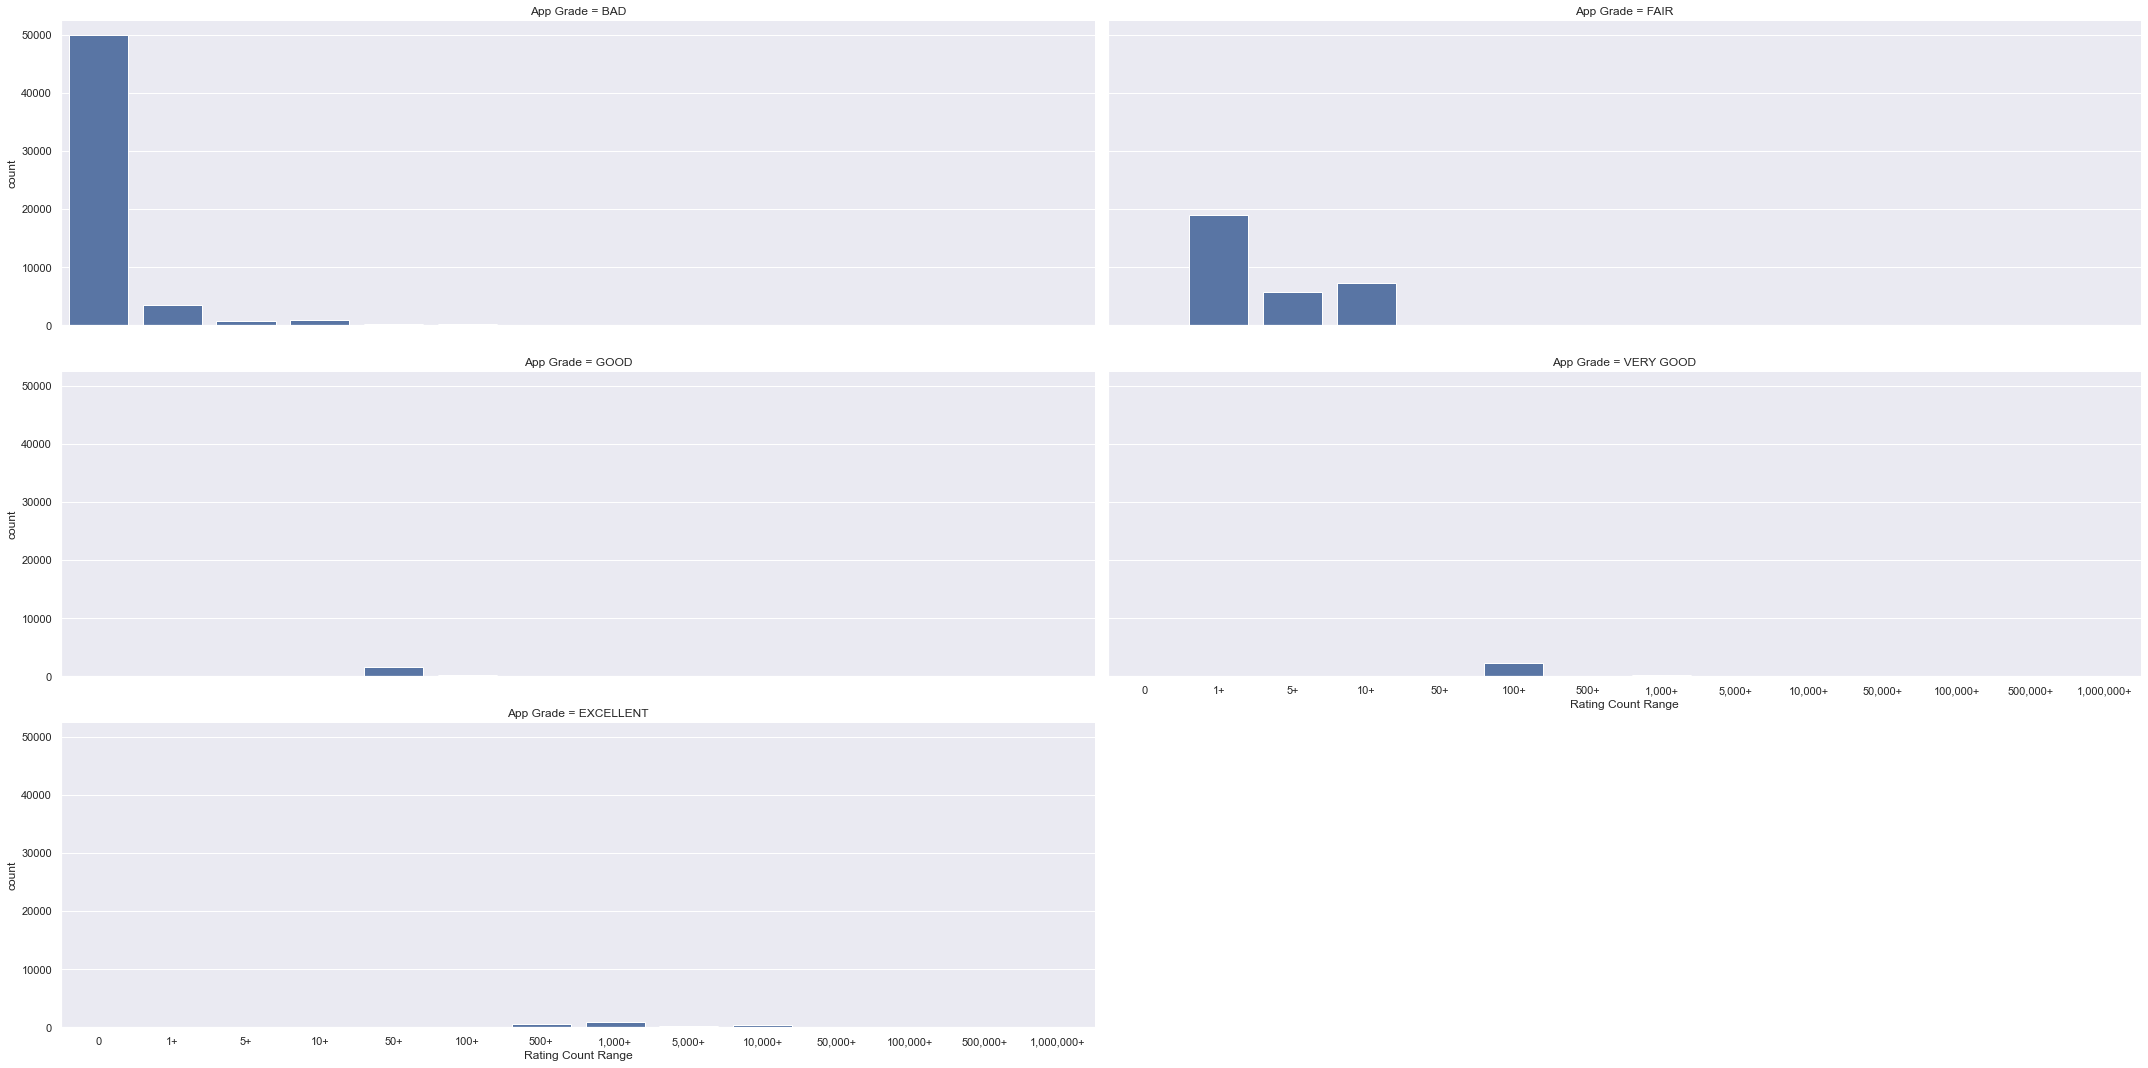

In [411]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=2, height=5, aspect=3.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

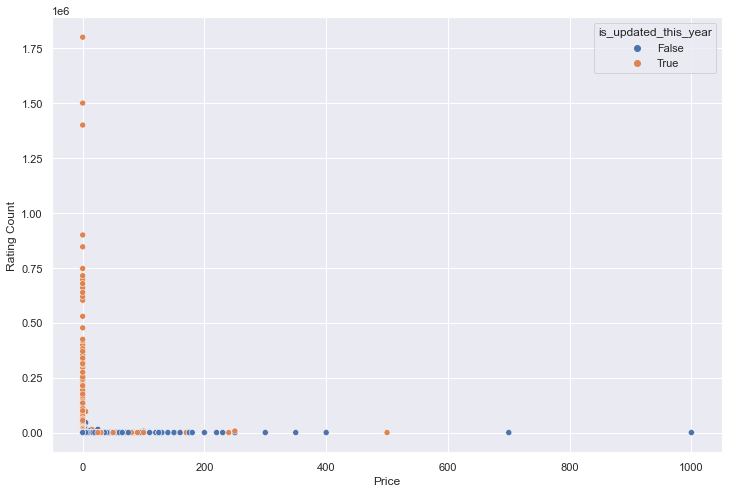

In [412]:
sbn.scatterplot(data=df, y='Rating Count', x='Price', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

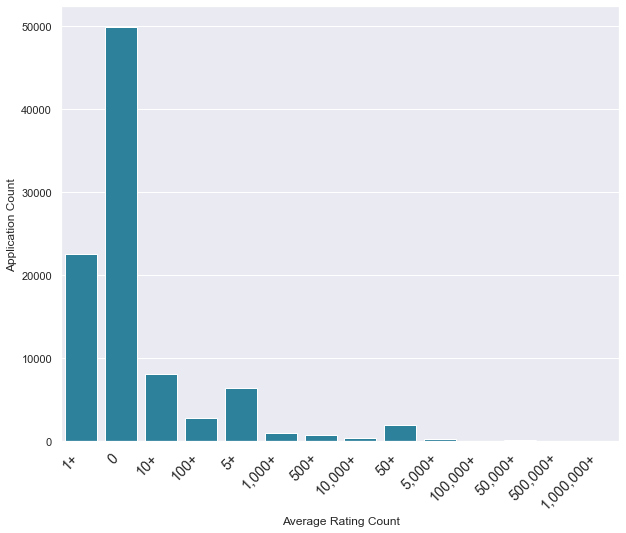

In [413]:
draw_count_plot(df, 'Rating Count Range', 'Average Rating Count', 'Application Count', fig_size=(10,8))

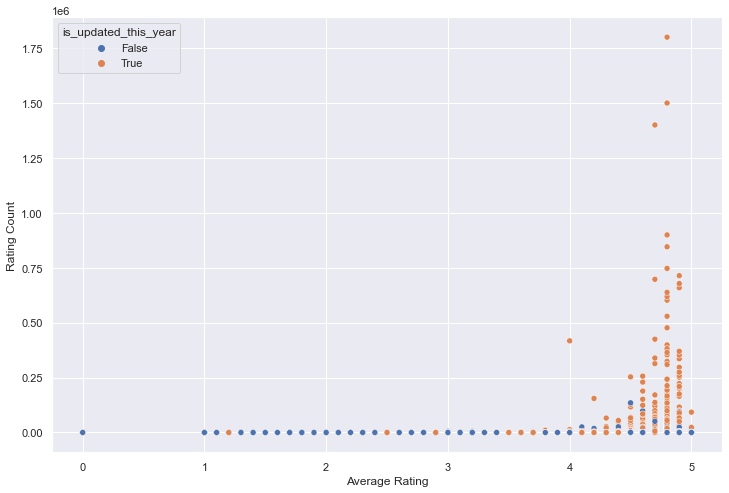

In [414]:
sbn.scatterplot(data=df, y='Rating Count', x='Average Rating', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

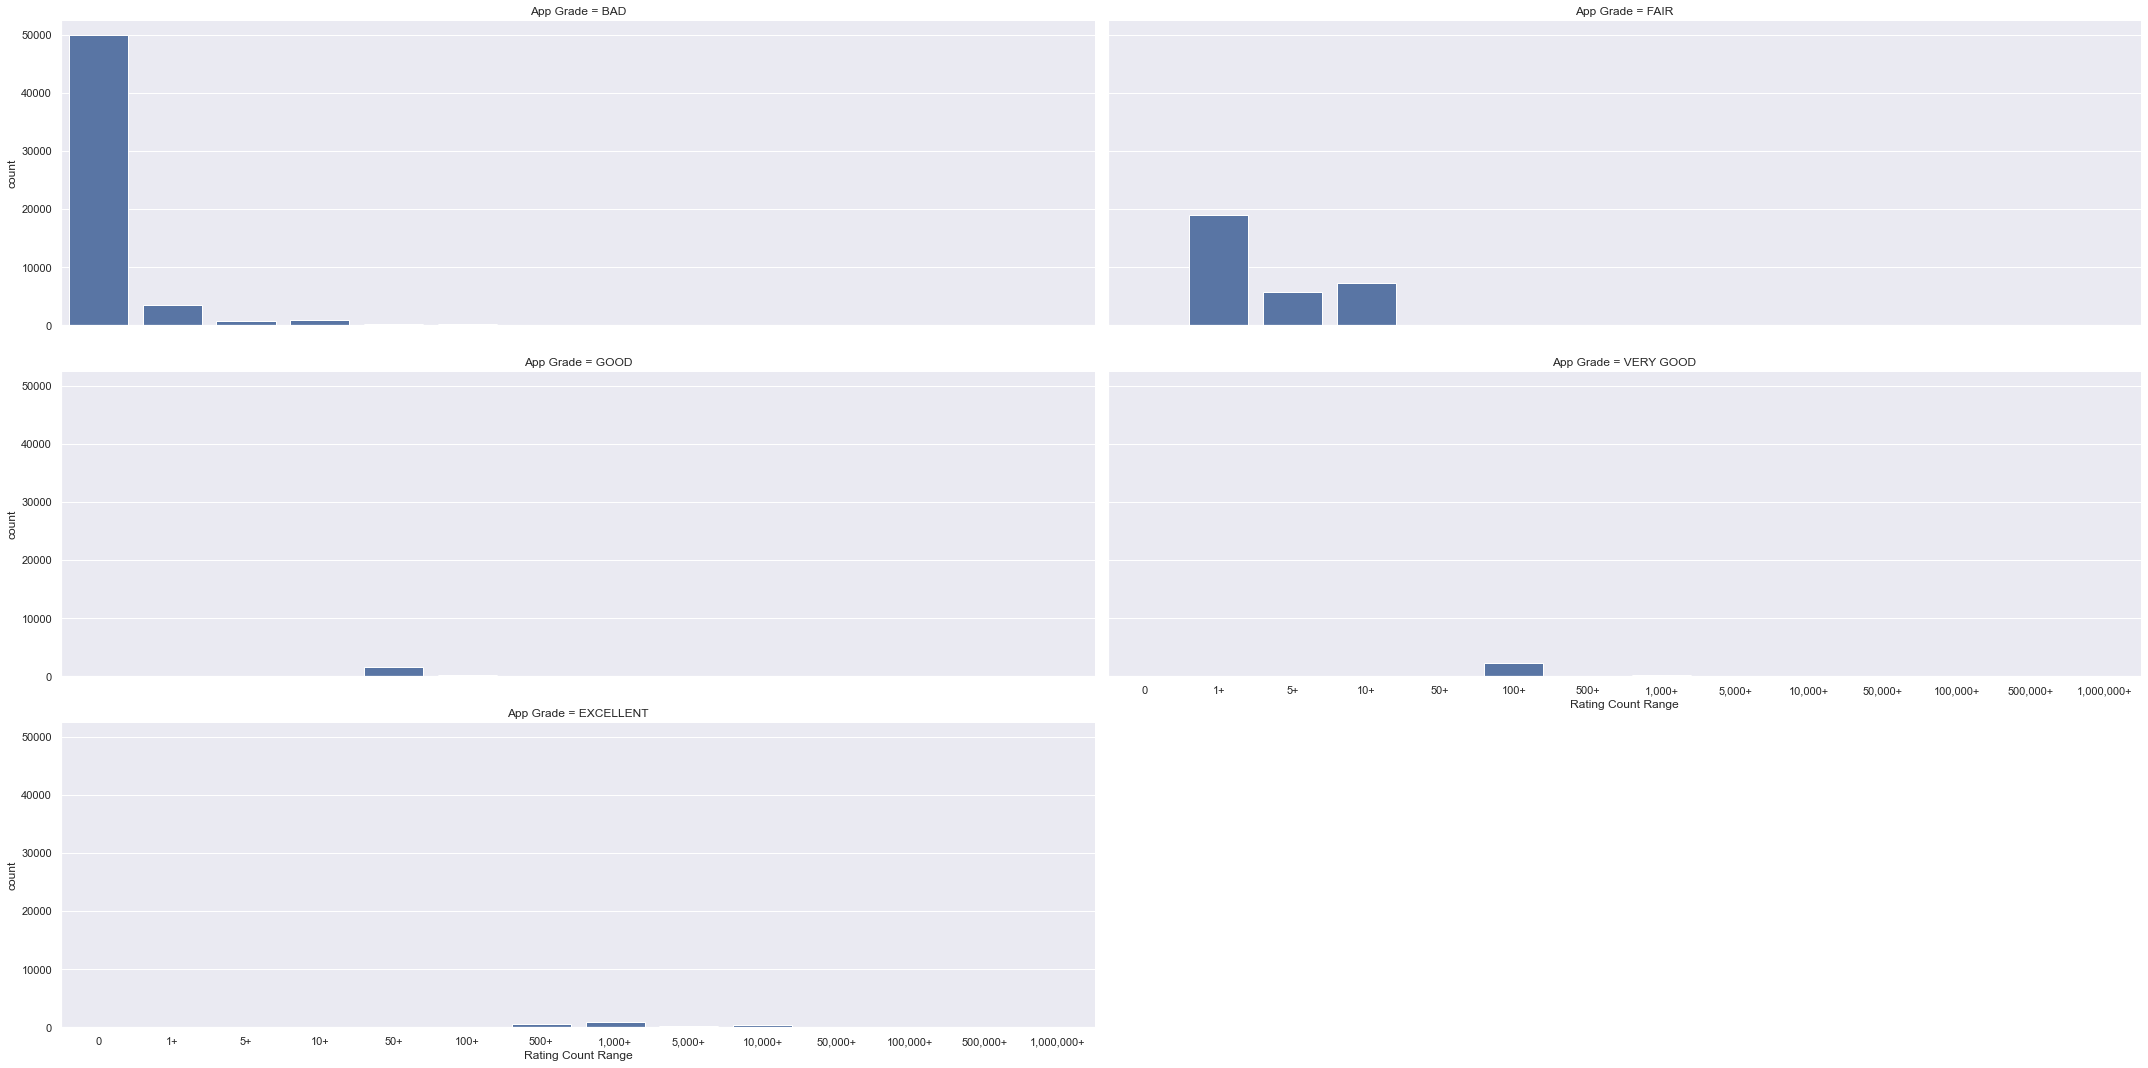

In [415]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=2, height=5, aspect=3.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

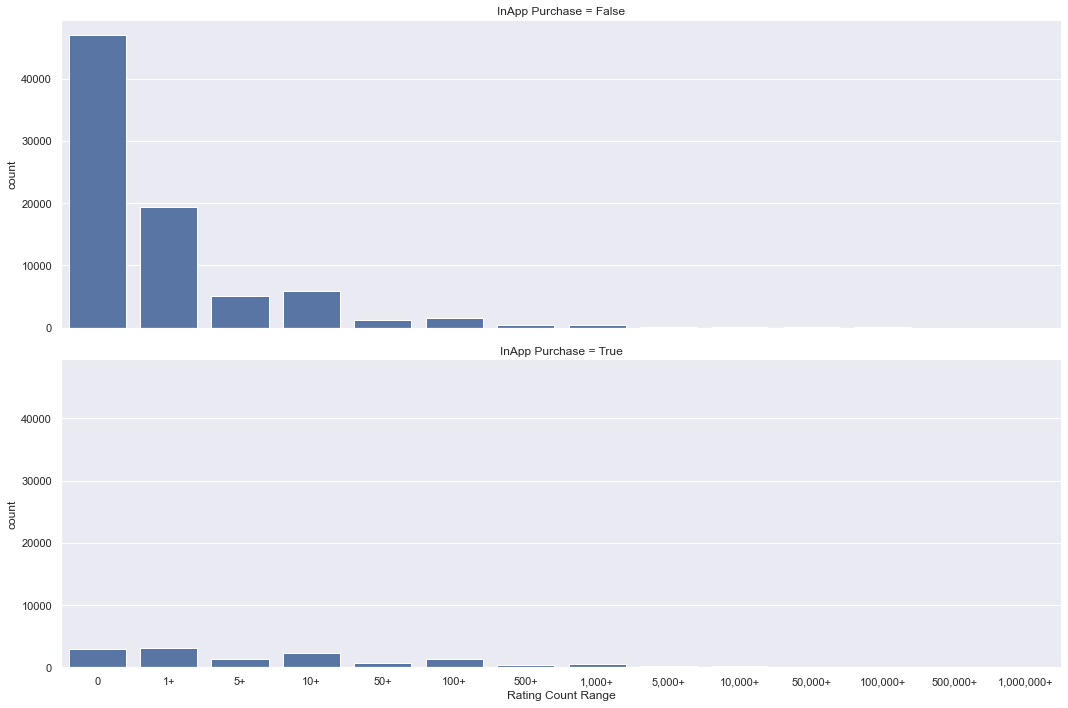

In [416]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="InApp Purchase", col_wrap=1, height=5, aspect=3.0)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

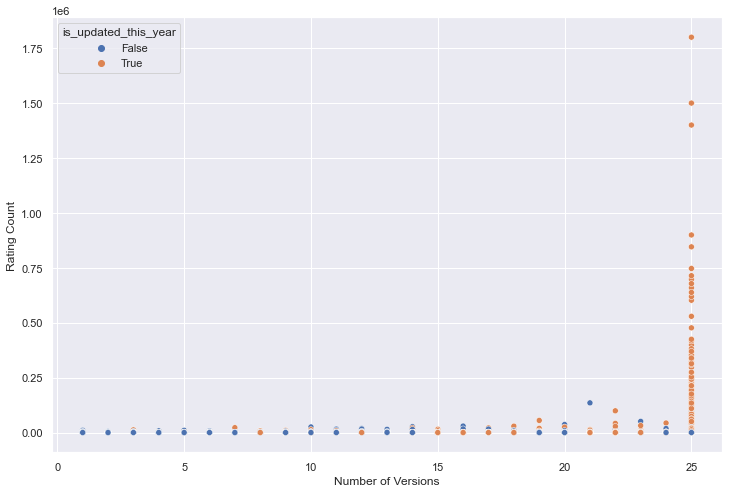

In [417]:
sbn.scatterplot(data=df, y='Rating Count', x='Number of Versions', hue='is_updated_this_year',
                legend='brief', color="#0a4020", palette="deep")
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

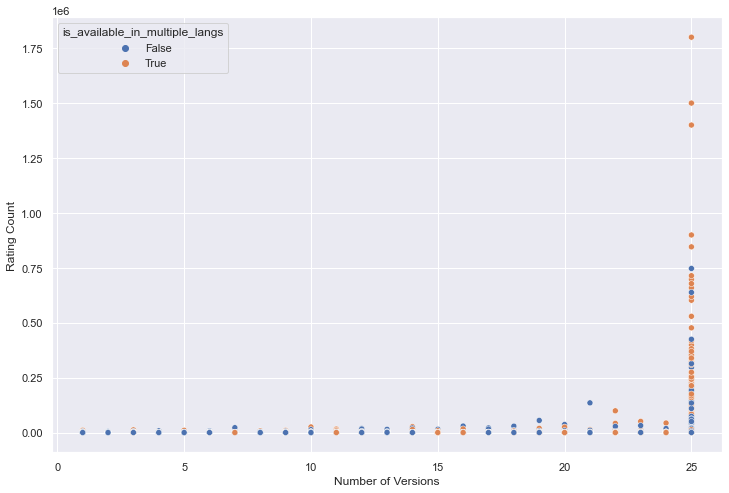

In [418]:
sbn.scatterplot(data=df, y='Rating Count', x='Number of Versions', hue='is_available_in_multiple_langs',
                legend='brief', color="#0a4020", palette="deep")
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

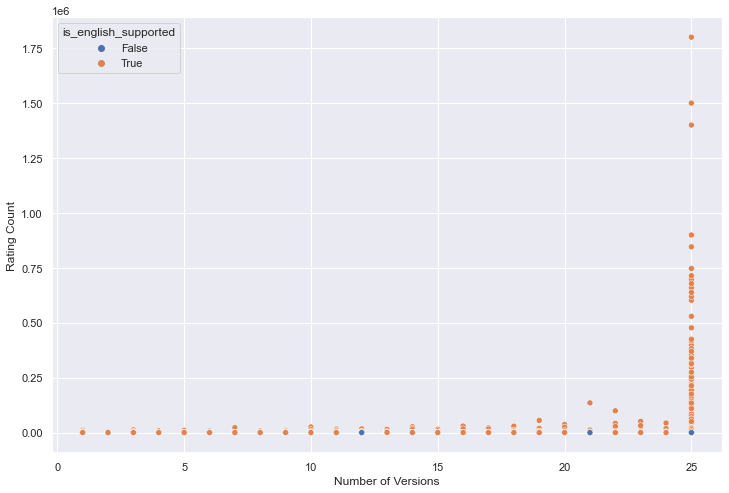

In [419]:
sbn.scatterplot(data=df, y='Rating Count', x='Number of Versions', hue='is_english_supported',
                legend='brief', color="#0a4020", palette="deep")
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

#### Application Type 

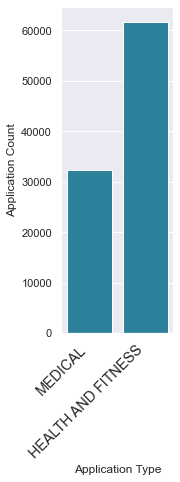

In [420]:
draw_count_plot(df, 'App Type', 'Application Type', 'Application Count', fig_size=(2,6))

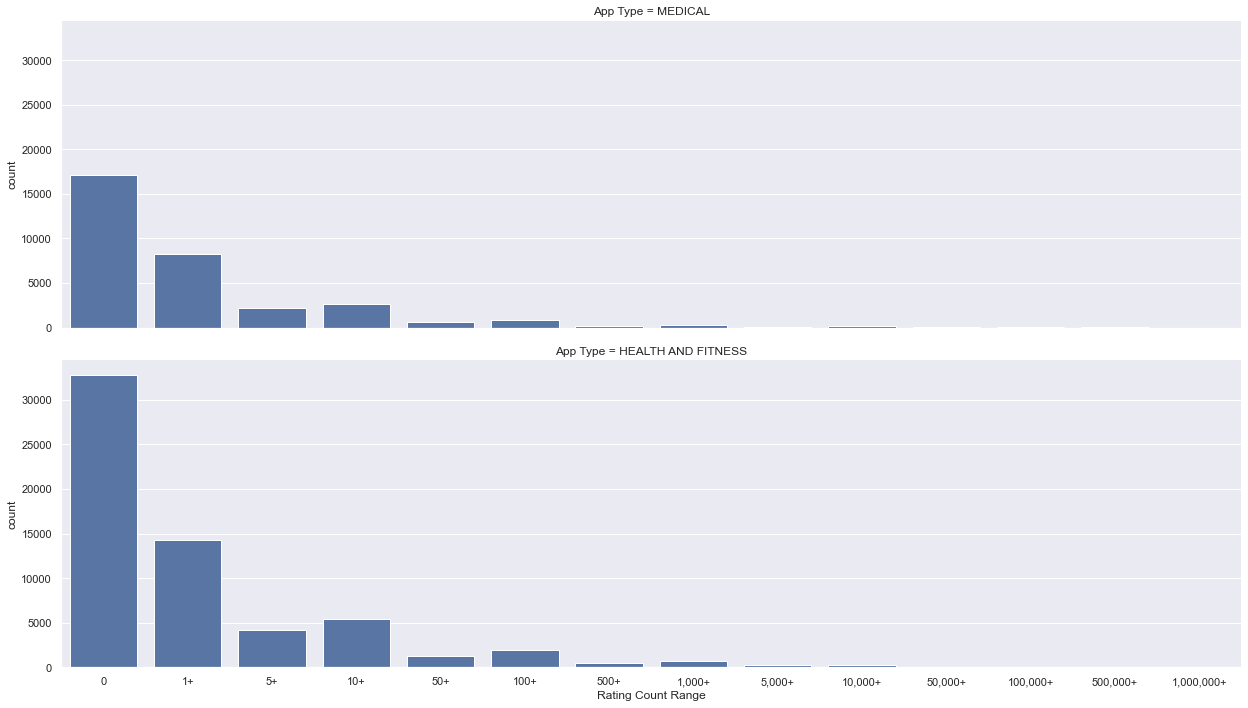

In [421]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Type", col_wrap=1, height=5, aspect=3.5)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

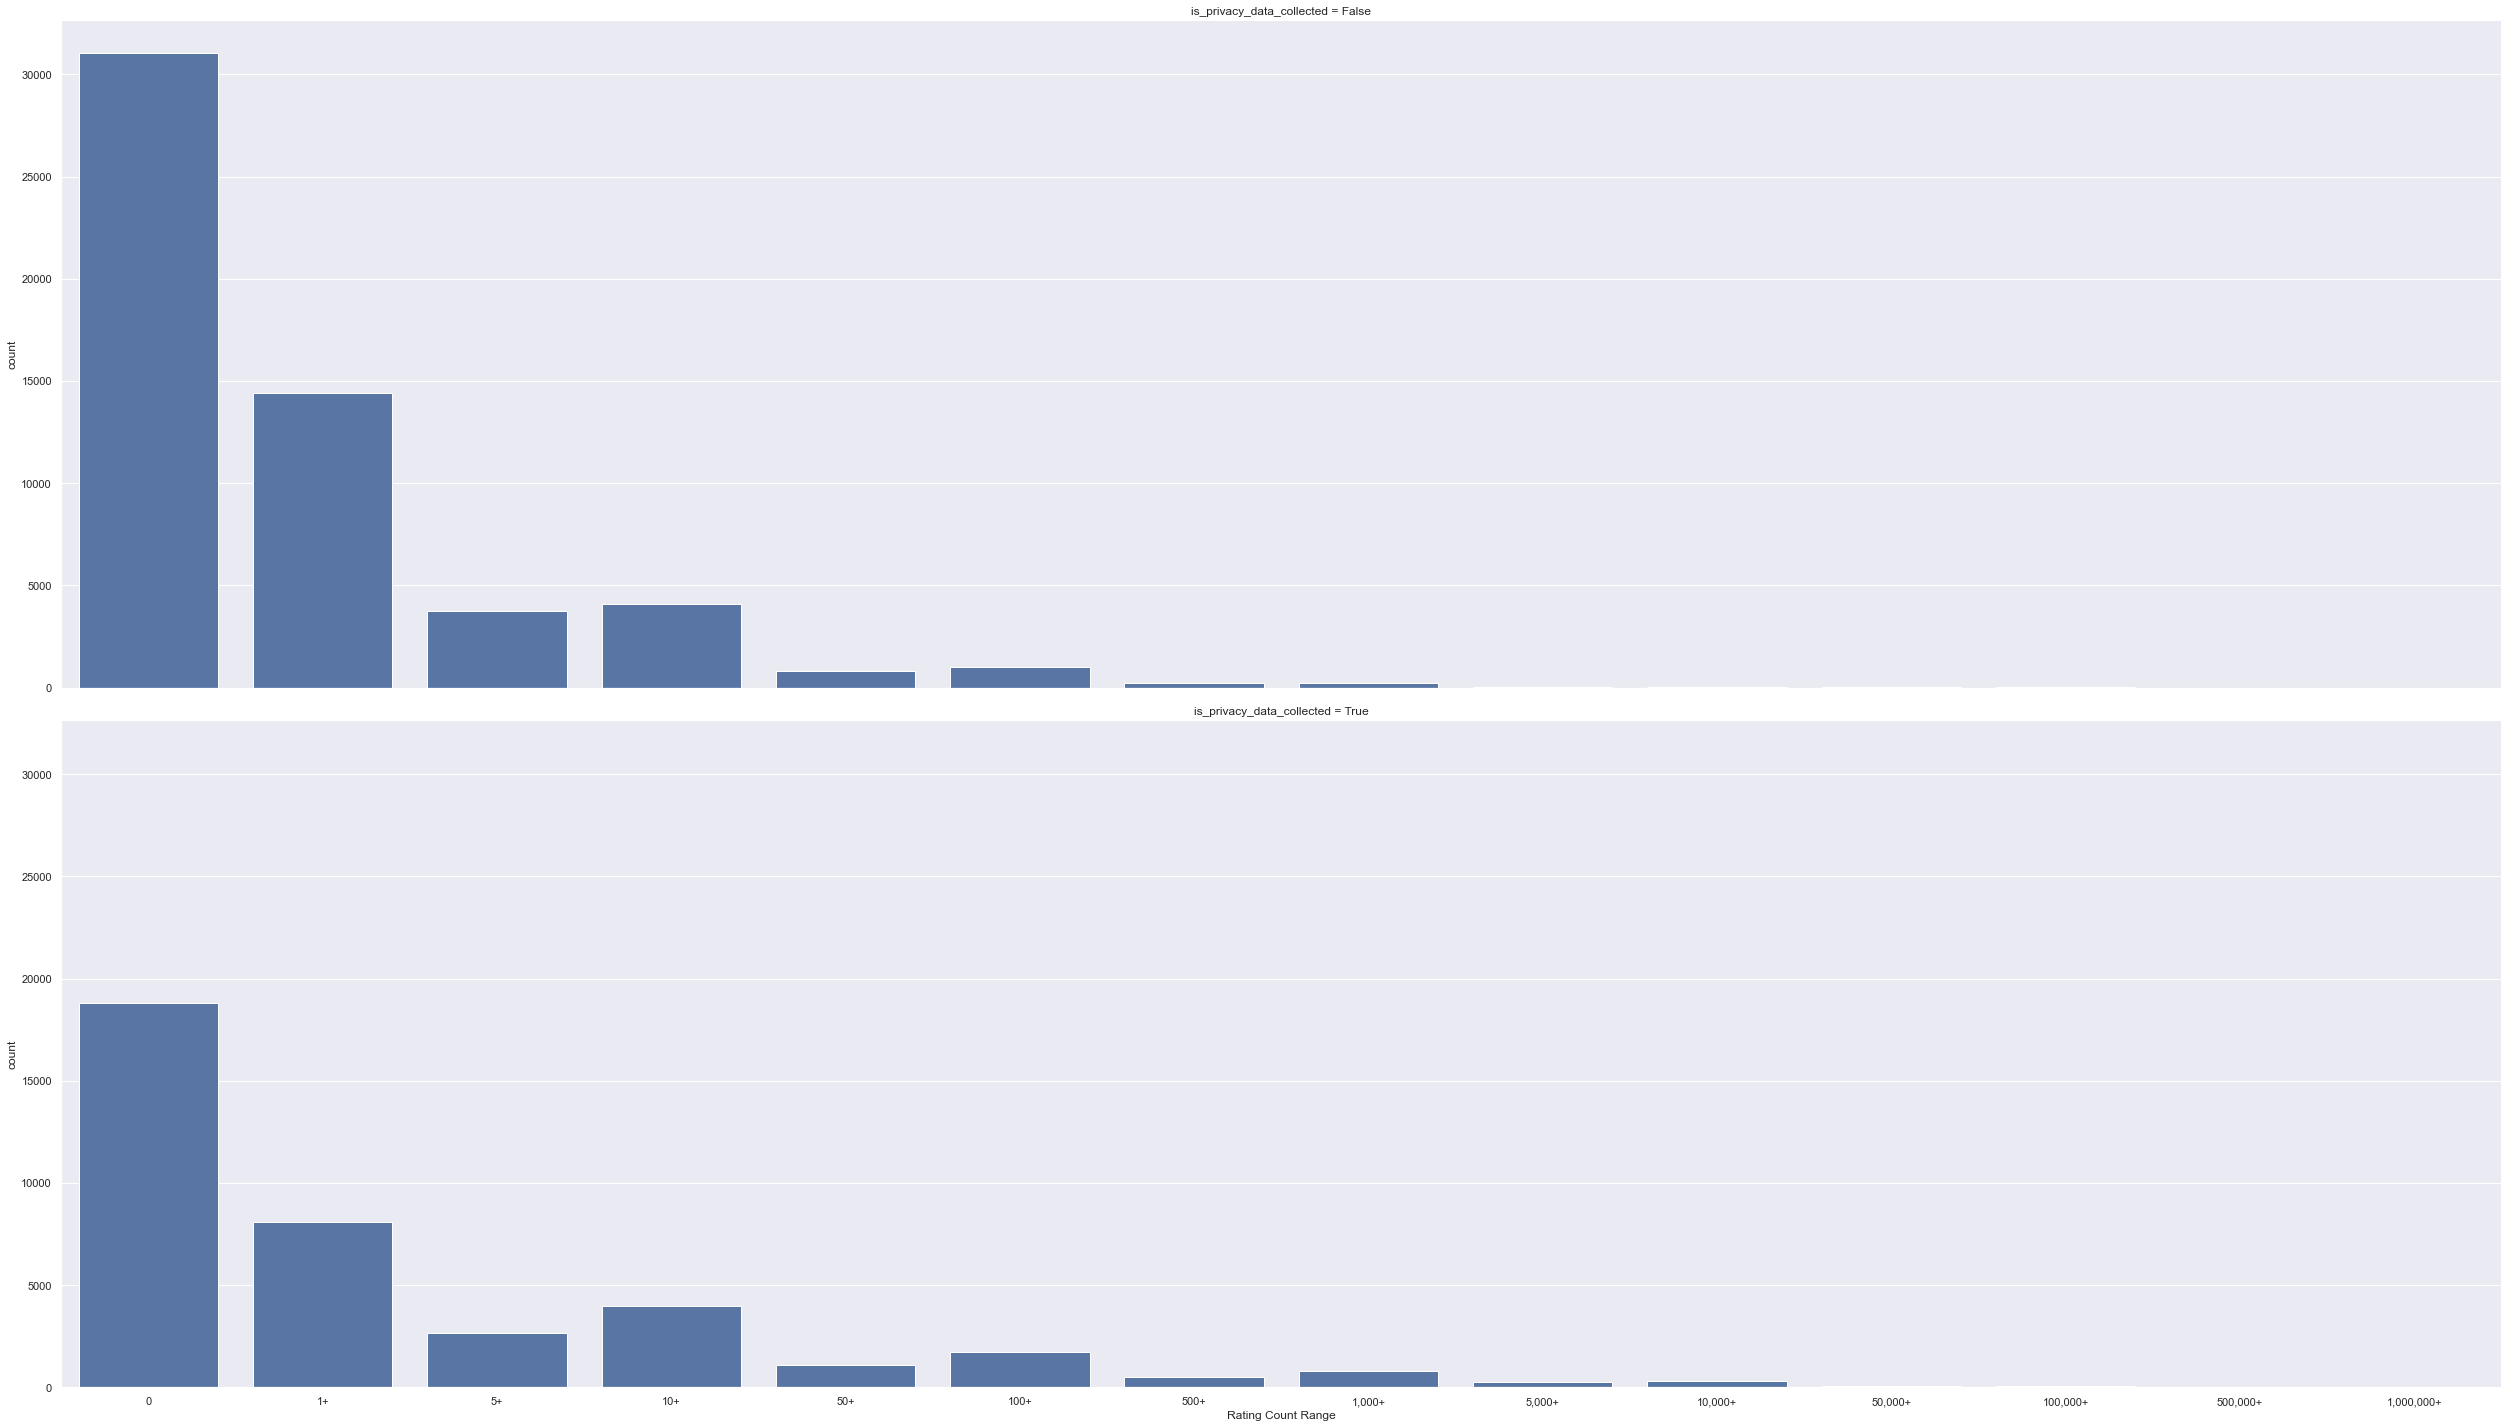

In [422]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="is_privacy_data_collected", col_wrap=1, height=10, aspect=3.5)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

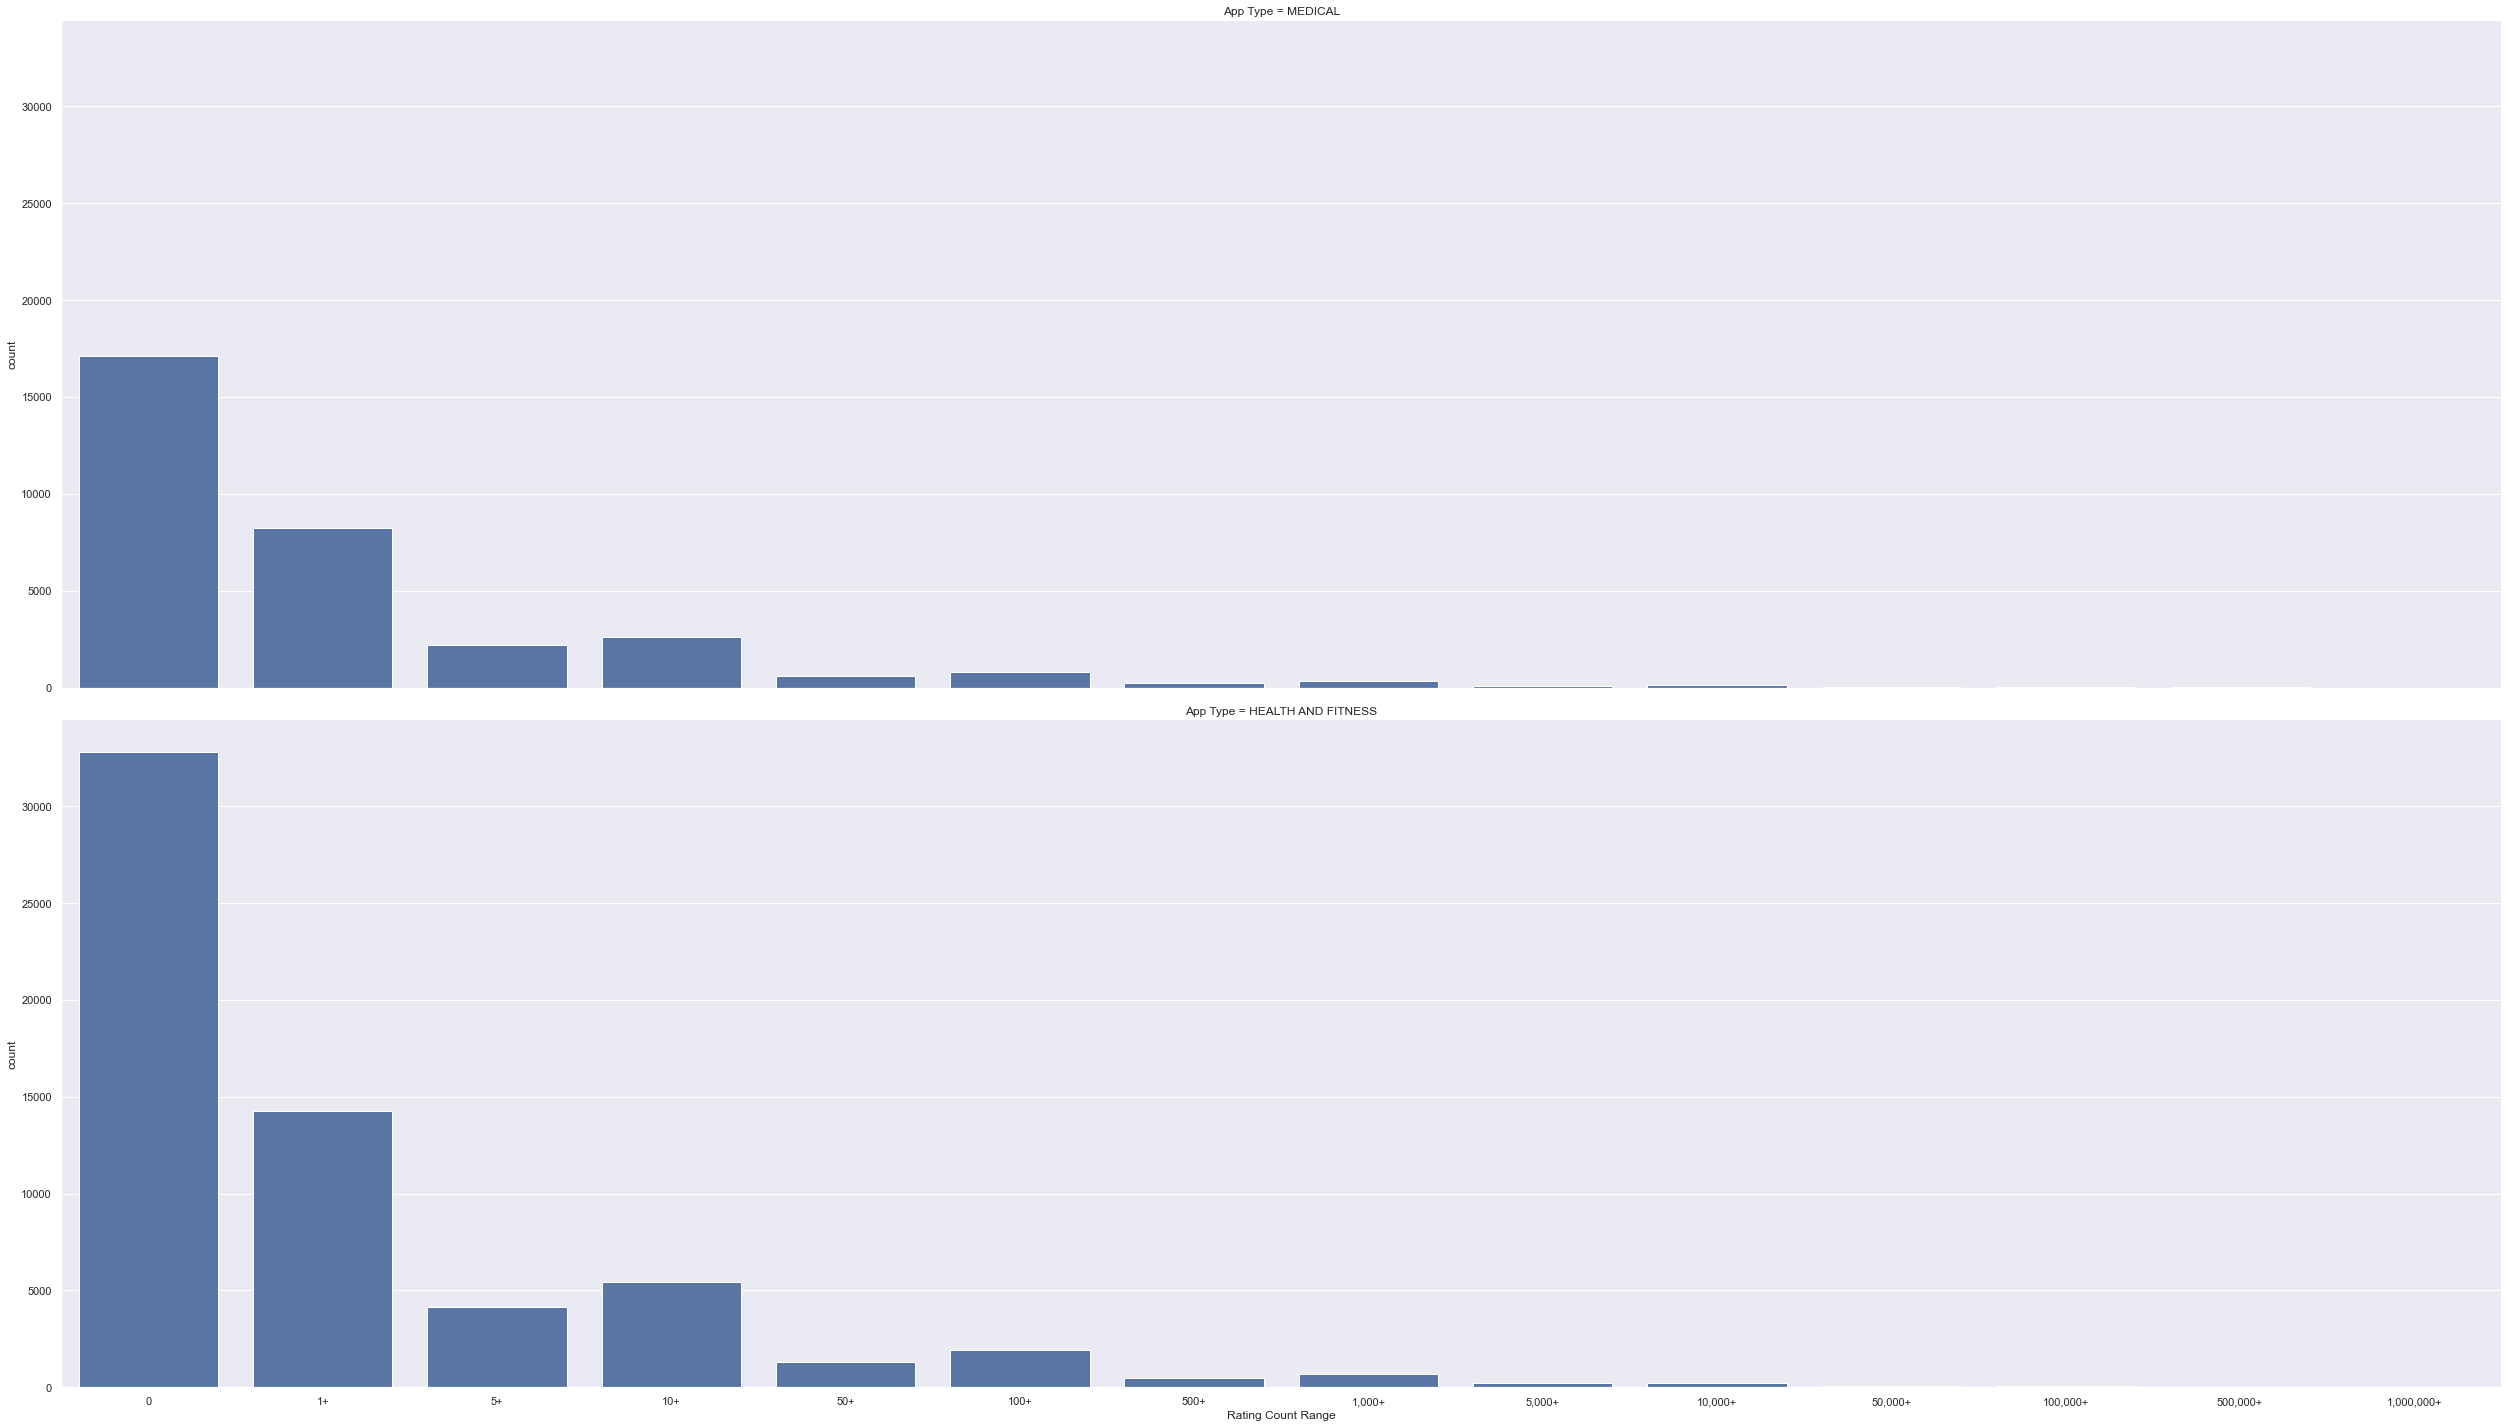

In [423]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Type" ,col_wrap=1, 
                                        height=10, aspect=3.5)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

In [424]:
df['is_privacy_data_collected'].value_counts()

False    55651
True     38328
Name: is_privacy_data_collected, dtype: int64

#### ASSOCIATION RULE MINING

In [425]:
def convert_consequent_to_str(consq):
    return str(consq).replace("frozenset({'", '').replace("})", '').replace("'", '')

In [426]:
def convert_antecedent_to_str(antecedent):
    antecedent = str(antecedent).replace("frozenset({'", '').replace("})", '').replace("'", '')
    return antecedent

In [427]:
def prepare_apriori_columns(df, column_list):
    apriori_df = list()
    for col in column_list:
        apriori_df.append(pd.get_dummies(df[col], prefix=col))
    apriori_df = pd.concat(apriori_df, axis=1)
    return apriori_df

def get_conditions_which_apps_are_most_likely_rated(min_support, min_threshold):
    apriori_df = prepare_apriori_columns(df,['Age Rating', 'InApp Purchase',
                                                       'App Grade', 'is_english_supported', 
                        'Service Type', 'is_available_in_multiple_langs', 'is_privacy_data_collected',
                                             'is_updated_this_year', 'Price Category'] )
    rules = apriori(apriori_df, min_support=min_support, use_colnames=True)
    association_rules_df = association_rules(rules, metric='confidence', min_threshold=min_threshold)
    association_rules_df["antecedent_len"] = association_rules_df["antecedents"].apply(lambda x: len(x))
    association_rules_df["consequents_len"] = association_rules_df["consequents"].apply(lambda x: len(x))
    association_rules_df['antecedents'] = association_rules_df['antecedents'].apply(convert_antecedent_to_str)
    association_rules_df['consequents'] = association_rules_df['consequents'].apply(convert_consequent_to_str)
    association_rules_df.sort_values(by=['confidence'], ascending=False, inplace=True)
    return association_rules_df[(association_rules_df['consequents_len']==1) & 
                                (association_rules_df['antecedent_len']>1)]

In [428]:
association_df = get_conditions_which_apps_are_most_likely_rated(0.5, 0.5)

In [429]:
def print_consequents_and_antecedents(df, consequent):
    filtered_df = df[df['consequents'].str.find(consequent) > -1]
    i = 1
    for index in filtered_df.index:
        if (i < 10):
            ants = filtered_df.at[index, 'antecedents']
            cons = filtered_df.at[index, 'consequents']
            support = filtered_df.at[index, 'support']
            conviction = filtered_df.at[index, 'conviction']
            confidence = filtered_df.at[index, 'confidence']
            print(f'{i}. {ants} => {cons} ({round(support,2), round(confidence,2), round(conviction,2)})')
            i = i + 1

In [430]:
print_consequents_and_antecedents(association_df,'Service Type')

1. App Grade_BAD, is_english_supported_True => Service Type_FREE ((0.5, 0.93, 1.08))
2. InApp Purchase_False, App Grade_BAD => Service Type_FREE ((0.51, 0.93, 1.07))
3. Age Rating_4+, is_english_supported_True => Service Type_FREE ((0.54, 0.92, 0.96))
4. InApp Purchase_False, is_english_supported_True => Service Type_FREE ((0.74, 0.92, 0.9))
5. is_available_in_multiple_langs_False, is_english_supported_True => Service Type_FREE ((0.57, 0.91, 0.87))
6. InApp Purchase_False, is_available_in_multiple_langs_False => Service Type_FREE ((0.53, 0.91, 0.82))
7. is_updated_this_year_False, is_english_supported_True => Service Type_FREE ((0.61, 0.91, 0.81))
8. is_updated_this_year_False, InApp Purchase_False => Service Type_FREE ((0.57, 0.9, 0.77))
9. is_updated_this_year_False, InApp Purchase_False, is_english_supported_True => Service Type_FREE ((0.54, 0.9, 0.75))


In [431]:
print_consequents_and_antecedents(association_df,'App Grade')

1. Service Type_FREE, InApp Purchase_False => App Grade_BAD ((0.51, 0.65, 1.16))
2. InApp Purchase_False, is_english_supported_True => App Grade_BAD ((0.5, 0.63, 1.1))
3. Service Type_FREE, is_english_supported_True => App Grade_BAD ((0.5, 0.58, 0.98))


In [432]:
print_consequents_and_antecedents(association_df,'Age Rating')

1. Service Type_FREE, is_english_supported_True => Age Rating_4+ ((0.54, 0.63, 1.01))


In [433]:
print_consequents_and_antecedents(association_df,'is_updated_this_year')

1. InApp Purchase_False, is_english_supported_True => is_updated_this_year_False ((0.59, 0.74, 1.08))
2. Service Type_FREE, InApp Purchase_False, is_english_supported_True => is_updated_this_year_False ((0.54, 0.73, 1.03))
3. Service Type_FREE, InApp Purchase_False => is_updated_this_year_False ((0.57, 0.72, 1.01))
4. Service Type_FREE, is_english_supported_True => is_updated_this_year_False ((0.61, 0.71, 0.97))


In [434]:
print_consequents_and_antecedents(association_df,'is_available_in_multiple_langs')

1. Service Type_FREE, InApp Purchase_False => is_available_in_multiple_langs_False ((0.53, 0.68, 0.97))
2. InApp Purchase_False, is_english_supported_True => is_available_in_multiple_langs_False ((0.53, 0.66, 0.93))
3. Service Type_FREE, is_english_supported_True => is_available_in_multiple_langs_False ((0.57, 0.66, 0.92))


In [435]:
print_consequents_and_antecedents(association_df,'is_english_supported')

1. Service Type_FREE, Age Rating_4+ => is_english_supported_True ((0.54, 0.94, 1.06))
2. is_updated_this_year_False, Service Type_FREE => is_english_supported_True ((0.61, 0.94, 1.05))
3. is_updated_this_year_False, InApp Purchase_False => is_english_supported_True ((0.59, 0.94, 1.04))
4. Service Type_FREE, InApp Purchase_False, is_updated_this_year_False => is_english_supported_True ((0.54, 0.94, 1.01))
5. Service Type_FREE, InApp Purchase_False => is_english_supported_True ((0.74, 0.93, 0.92))
6. InApp Purchase_False, App Grade_BAD => is_english_supported_True ((0.5, 0.91, 0.75))
7. Service Type_FREE, App Grade_BAD => is_english_supported_True ((0.5, 0.91, 0.74))
8. Service Type_FREE, is_available_in_multiple_langs_False => is_english_supported_True ((0.57, 0.91, 0.67))
9. InApp Purchase_False, is_available_in_multiple_langs_False => is_english_supported_True ((0.53, 0.9, 0.66))


In [436]:
print_consequents_and_antecedents(association_df,'Price Category')

#### CLUSTERING

In [437]:
df[:5]

,Unnamed: 0,App Name,Size,Age Rating,Languages,Price,InApp Purchase,Average Rating,Rating Count,Privacy Data,App Link,Number of Versions,Last Version Date,First Version Date,App Type,is_english_supported,Service Type,Rating Count Range,is_available_in_multiple_langs,is_privacy_data_collected,is_app_ever_updated,Price Category,is_updated_this_year,App Grade
0,0,H and W Drug Store,21.5 MB,12+,"English, Spanish",0.00,False,4.0,4,NaN,https://apps.apple.com/us/app/h-and-w-drug-sto...,1,NaN,NaN,MEDICAL,True,FREE,1+,True,False,False,None,False,FAIR
1,1,H&P-card™,10.1 MB,17+,"English, Spanish",2.99,False,1.0,1,NaN,https://apps.apple.com/us/app/h-p-card/id56971...,5,"Sep 28, 2020","Oct 20, 2012",MEDICAL,True,PAID,1+,True,False,True,1+,False,BAD
2,2,H-Book – osobní zdravotní záznamy,47.1 MB,12+,"English, Czech",0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-book-osobn%C3%...,21,"Jun 28, 2017","Jun 5, 2013",MEDICAL,True,FREE,0,True,False,True,None,False,BAD
3,3,H-FACT,4.1 MB,12+,English,0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-fact/id1568969345,5,"Nov 24, 2021","Jul 5, 2021",MEDICAL,True,FREE,0,False,False,True,None,False,BAD
4,4,H-Module,27.6 MB,17+,Not Specified,0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-module/id15728...,2,"Jun 26, 2021","Jun 22, 2021",MEDICAL,False,FREE,0,False,False,True,None,False,BAD


- Price
- Average Rating
- Rating count
- Number of versions
- 

In [438]:
def get_age_integer(age_rating):
    return int(age_rating.replace('+',''))

In [439]:
df['age_rating_integer'] = df['Age Rating'].apply(get_age_integer)

In [440]:
def draw_elbow_graph(kmeans_df):
    wcss=[]
    for i in range(1,15):
        kmeans = KMeans(i)
        kmeans.fit(kmeans_df)
        wcss_iter = kmeans.inertia_
        wcss.append(wcss_iter)

    number_clusters = range(1,15)
    pyplot.subplot(2, 2, 1)
    pyplot.plot(number_clusters,wcss)
    pyplot.title('The Elbow title')
    pyplot.xlabel('Number of clusters')
    pyplot.ylabel('WCSS')
    fig = pyplot.gcf()
    fig.set_size_inches(24, 16)

In [441]:
def execute_kmeans(df, columns,n_cluster):
    standard_scaler = StandardScaler()
    kmeans_df = df[columns]
    kmeans_df_scaled = standard_scaler.fit_transform(kmeans_df)
    draw_elbow_graph(kmeans_df_scaled)
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(kmeans_df_scaled)
    labels = kmeans.predict(kmeans_df_scaled)
    centroids = kmeans.cluster_centers_
    kmeans_df_cluster = kmeans_df.copy()
    kmeans_df_cluster['cluster'] = labels
#     print(kmeans_df_cluster['cluster'].value_counts())
    if (len(columns) == 3):
        ax = pyplot.subplot(2, 2, 2, projection='3d')
        ax.scatter(kmeans_df_scaled[:,0], kmeans_df_scaled[:,1], kmeans_df_scaled[:,2] ,c=kmeans.labels_, 
                   cmap='rainbow',
               edgecolor='k', s=40, alpha = 0.5)
        ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
               kmeans.cluster_centers_[:,2], s = 300, c = 'r',
               marker='*', label = 'Centroid')
    elif (len(columns) == 4):
        ax = pyplot.subplot(2, 2, 2, projection='3d')
        ax.scatter(kmeans_df_scaled[:,0], kmeans_df_scaled[:,1], kmeans_df_scaled[:,2] , kmeans_df_scaled[:,3]
                   ,c=kmeans.labels_, 
                   cmap='rainbow',
               edgecolor='k', s=40, alpha = 0.5)
        ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
               kmeans.cluster_centers_[:,2], kmeans.cluster_centers_[:,3], s = 300, c = 'r',
               marker='*', label = 'Centroid')
    else:
        ax = pyplot.subplot(2, 2, 2)
        ax.scatter(kmeans_df_scaled[:, 0],kmeans_df_scaled[:, 1],
            c=kmeans.labels_,cmap='rainbow')
    
    fig = pyplot.gcf()
    fig.set_size_inches(20, 16)
    return kmeans_df_cluster

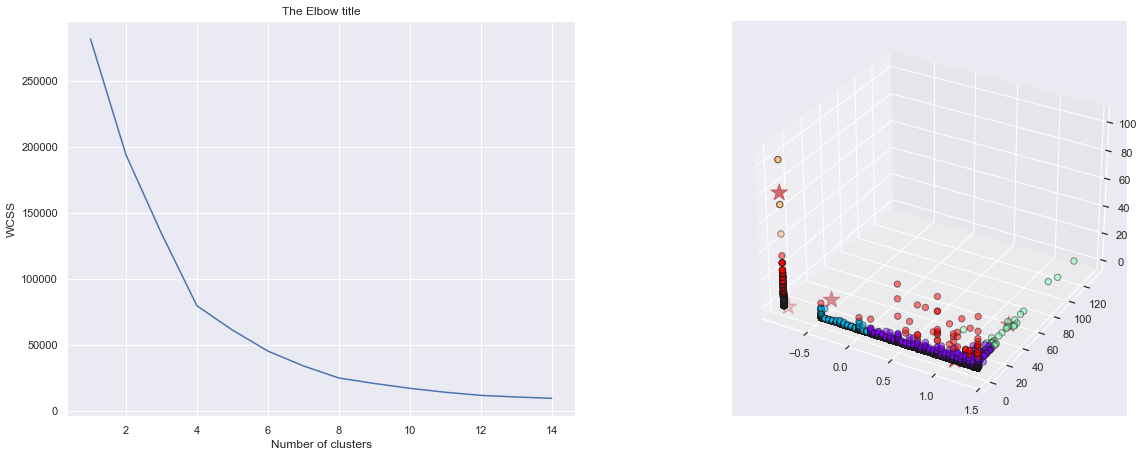

In [442]:
kmeans_df_cluster_df3 = execute_kmeans(df, ['Average Rating', 'Rating Count', 'Price'], 5)

In [443]:
kmeans_df_cluster_df3['cluster'].value_counts()

1    54443
0    39328
4      178
2       25
3        5
Name: cluster, dtype: int64

In [444]:
kmeans_df_cluster_df3.groupby(by='cluster').min()

,Average Rating,Rating Count,Price
cluster,,,
0,2.3,1,0.00
1,0.0,0,0.00
2,4.0,335900,0.00
3,0.0,0,499.99
4,0.0,0,74.99


In [445]:
kmeans_df_cluster_df3.groupby(by='cluster').max()

,Average Rating,Rating Count,Price
cluster,,,
0,5.0,323600,69.99
1,2.2,3200,69.99
2,4.9,1800000,0.00
3,0.0,0,999.99
4,5.0,6900,399.99


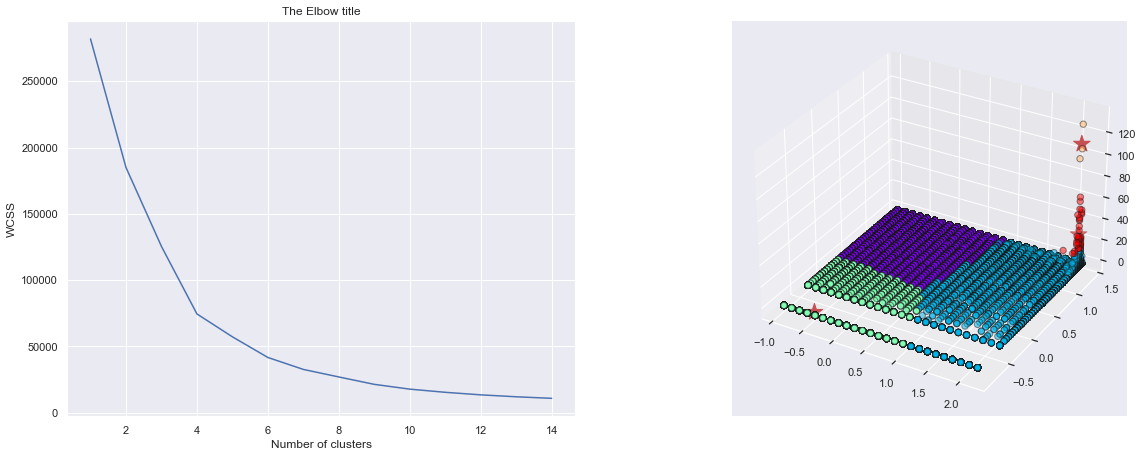

In [446]:
kmeans_df_cluster_df4 = execute_kmeans(df, ['Number of Versions', 'Average Rating', 'Rating Count'], 5)

In [447]:
kmeans_df_cluster_df4['cluster'].value_counts()

2    49361
0    27275
1    17303
4       37
3        3
Name: cluster, dtype: int64

In [448]:
kmeans_df_cluster_df4.groupby(by='cluster').min()

,Number of Versions,Average Rating,Rating Count
cluster,,,
0,1,2.2,1
1,13,0.0,0
2,1,0.0,0
3,25,4.7,1400000
4,25,4.0,222800


In [449]:
kmeans_df_cluster_df4.groupby(by='cluster').max()

,Number of Versions,Average Rating,Rating Count
cluster,,,
0,15,5.0,26700
1,25,5.0,213300
2,16,2.3,1500
3,25,4.8,1800000
4,25,4.9,899500


#### CLASSIFICATION MODEL

In [450]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93979 entries, 0 to 93978
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      93979 non-null  int64  
 1   App Name                        93979 non-null  object 
 2   Size                            93979 non-null  object 
 3   Age Rating                      93979 non-null  object 
 4   Languages                       93979 non-null  object 
 5   Price                           93979 non-null  float64
 6   InApp Purchase                  93979 non-null  bool   
 7   Average Rating                  93979 non-null  float64
 8   Rating Count                    93979 non-null  int64  
 9   Privacy Data                    38328 non-null  object 
 10  App Link                        93979 non-null  object 
 11  Number of Versions              93979 non-null  int64  
 12  Last Version Date               

In [451]:
def draw_heatmap():
    df_num = df[['Price', 'Rating Count', 'Number of Versions', 'Average Rating']]
    ax = sbn.heatmap( df_num.corr(method='spearman'), cmap = 'rainbow', annot=True)
    fig = pyplot.gcf()
    fig.set_size_inches(8, 6)
    pyplot.xlabel('Correlation map for Android features')

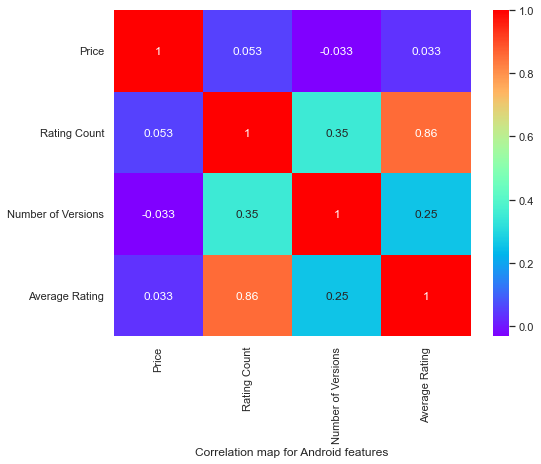

In [452]:
draw_heatmap()

##### Rating count is a good variable to determine the average rating based on correlation

In [453]:
target_attributes = ['Price Category Ord', 'Rating Count Range Ord', 'Number of Versions', 'Age Rating Ord', 'InApp Purchase Ord',
                    'is_english_supported Ord', 'is_available_in_multiple_langs Ord', 'Service Type Ord',
                     'App Type Ord', 'is_privacy_data_collected Ord', 'is_app_ever_updated Ord',
                     'is_updated_this_year Ord' ]

In [454]:
df['Price Category'].isna().any()

True

In [455]:
(df['Price Category'].unique())

array([None, '1+', '100+', '5+', '0+', '10+', '50+', '500+'], dtype=object)

In [456]:
def create_ordinal_fields(df):
    age_rating_map = {'4+' : 3, '9+' : 2, '12+' : 1, '17+' : 0 }
    app_grading_map = {'EXCELLENT' : 4, 'VERY GOOD' : 3, 'GOOD' : 2, 'FAIR' : 1, 'BAD' : 0 }
    rating_count_map = {'0' : 0, '1+' : 1, '5+' : 2, '10+' : 3, '50+' : 4, '100+' : 5, '500+' : 6, '1,000+' : 7,
                       '5,000+' : 8, '10,000+' : 9, '50,000+' : 10, '100,000+' : 11, '500,000+' : 12, '1,000,000+': 13}
    price_map = {np.nan : 0, 'None' : 0, '0+' : 1, '1+' : 1, '5+' : 2, '10+' : 3, '50+' : 4, '100+' : 5, '500+' : 6}
    inapp_purchase_map = {True : 1, False : 0}
    service_type_map = {'PAID' : 1, 'FREE' : 0}
    app_type_map = {'MEDICAL' : 1, 'HEALTH AND FITNESS' : 0}
    english_supported_map = {True : 1, False : 0}
    available_in_multiple_langs_map = {True : 1, False : 0}
    privacy_data_collected_map = {True : 1, False : 0}
    app_ever_updated_map = {True : 1, False : 0}
    updated_this_year_map = {True : 1, False : 0}
    df['Age Rating Ord'] = df['Age Rating'].replace(age_rating_map)
    df['InApp Purchase Ord'] = df['InApp Purchase'].replace(inapp_purchase_map)
    df['is_english_supported Ord'] = df['is_english_supported'].replace(english_supported_map)
    df['is_available_in_multiple_langs Ord'] = df['is_available_in_multiple_langs'].replace(available_in_multiple_langs_map)
    df['is_privacy_data_collected Ord'] = df['is_privacy_data_collected'].replace(privacy_data_collected_map)
    df['is_app_ever_updated Ord'] = df['is_app_ever_updated'].replace(app_ever_updated_map)
    df['is_updated_this_year Ord'] = df['is_updated_this_year'].replace(updated_this_year_map)
    df['App Grade Ord'] = df['App Grade'].replace(app_grading_map)
    df['Service Type Ord'] = df['Service Type'].replace(service_type_map)
    df['Rating Count Range Ord'] = df['Rating Count Range'].replace(rating_count_map)
    df['App Type Ord'] = df['App Type'].replace(app_type_map)
    df['Price Category Ord'] = df['Price Category'].replace(price_map)
    return df


In [457]:
updated_df = create_ordinal_fields(df.copy())

In [458]:
def draw_heatmap(df):
    df_num = df[['Price Category Ord', 'Number of Versions', 'is_privacy_data_collected Ord',
                 'is_updated_this_year Ord', 'is_available_in_multiple_langs Ord', 'is_english_supported Ord',
                 'InApp Purchase Ord', 'is_app_ever_updated Ord',
                'Service Type Ord','Rating Count Range Ord', 'App Type Ord', 'Age Rating Ord', 'App Grade Ord']]
    ax = sbn.heatmap( df_num.corr(method='spearman'), cmap = 'rainbow', annot=True)
    fig = pyplot.gcf()
    fig.set_size_inches(18, 8)
    font = {'family': 'Times New Roman','color':  'black','weight': 'bold','size': 16}
    pyplot.xlabel('Correlation map for Ios dataset features', fontdict=font)

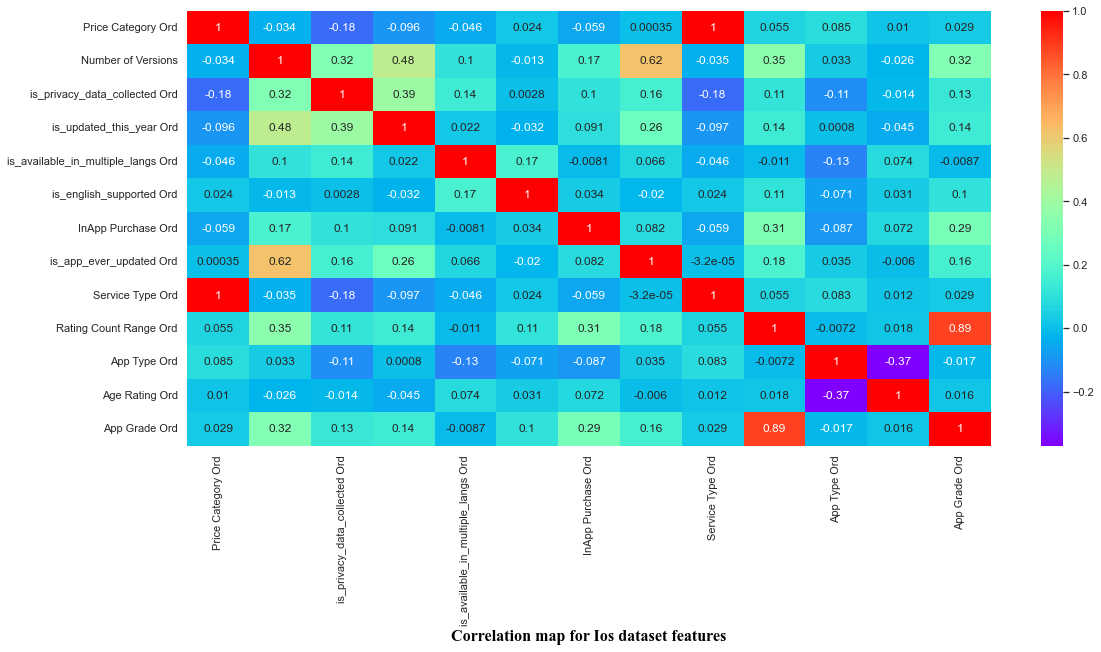

In [459]:
draw_heatmap(updated_df)

In [460]:
def get_top_features(no_of_features, X, Y):
    selector = SelectKBest(chi2, k="all") 
    selector.fit(X[target_attributes], Y)
    scores = (selector.scores_)
    argument_sort = list(np.argsort(scores))
    selected_attributes, selected_attribute_scores = [], []
    for i in range(len(target_attributes)-no_of_features,len(target_attributes)):
        value = argument_sort[i]
        selected_attributes.append(target_attributes[value])
        selected_attribute_scores.append(scores[value])
    return selected_attributes, selected_attribute_scores

In [461]:
selected_attributes, selected_attributes_score = get_top_features(7, 
                                            updated_df, 
                                             updated_df['App Grade Ord'])

In [462]:
selected_attributes_score

[153.48162461088143,
 388.99289488356226,
 1595.6396931723118,
 2288.491501741103,
 9267.104410419417,
 105384.22907204225,
 196545.3027506937]

In [463]:
selected_attributes

['is_available_in_multiple_langs Ord',
 'is_app_ever_updated Ord',
 'is_privacy_data_collected Ord',
 'is_updated_this_year Ord',
 'InApp Purchase Ord',
 'Number of Versions',
 'Rating Count Range Ord']

In [464]:
updated_df['App Grade'].value_counts()

BAD          55269
FAIR         32006
VERY GOOD     2573
EXCELLENT     2118
GOOD          2013
Name: App Grade, dtype: int64

Text(0.5, 0, 'SelectKBest for top 7 features (iOS)')

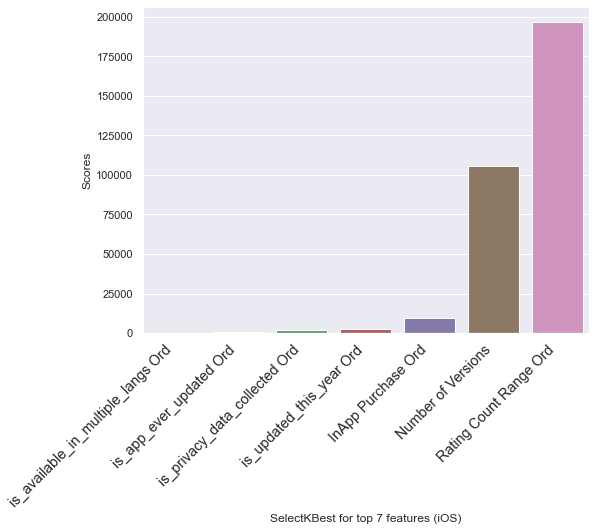

In [465]:
sbn.barplot(x=selected_attributes, y=selected_attributes_score)
set_plot_labels('Attributes', 'Scores', 'large')
fig = pyplot.gcf()
fig.set_size_inches(8, 6)
pyplot.xlabel('SelectKBest for top 7 features (iOS)')

In [466]:
filtered_attributes = ['Rating Count Range Ord', 'Number of Versions', 'is_privacy_data_collected Ord',
                     'InApp Purchase Ord', 'is_updated_this_year Ord']

In [467]:
updated_df['App Grade Ord'].value_counts()

0    55269
1    32006
3     2573
4     2118
2     2013
Name: App Grade Ord, dtype: int64

In [468]:
X_train, X_test, y_train, y_test = train_test_split(updated_df[filtered_attributes],
                                                    updated_df['App Grade Ord'], test_size=0.25, random_state=42)

In [469]:
y_train.value_counts()

0    41352
1    24095
3     1951
4     1555
2     1531
Name: App Grade Ord, dtype: int64

In [470]:
def oversample_train_data(X_train, y_train):
    oversampler = SMOTE()
    oversampled_df_X, oversampled_df_Y = oversampler.fit_resample(X_train, y_train)
    return oversampled_df_X, oversampled_df_Y

In [471]:
oversampled_df_X, oversampled_df_Y = oversample_train_data(X_train, y_train)

In [472]:
oversampled_df_Y.value_counts()

0    41352
1    41352
4    41352
3    41352
2    41352
Name: App Grade Ord, dtype: int64

In [473]:
def create_and_fit_model(X, Y):
    clf = DecisionTreeClassifier()
    fitted_model = clf.fit(X,Y)
    print('Training score => ', fitted_model.score(X, Y))
    return fitted_model

In [474]:
fitted_model = create_and_fit_model(oversampled_df_X[filtered_attributes], oversampled_df_Y)

Training score =>  0.9318291739214548


In [475]:
def compute_validation_accuracy_and_classification_report(test_X, test_Y):
    y_pred = fitted_model.predict(test_X)
    print('Validation accuracy => ', fitted_model.score(test_X, test_Y))
    target_names = ['BAD','FAIR','GOOD', 'VERY GOOD', 'EXCELLENT']
    print(classification_report(test_Y, y_pred, target_names=target_names))

In [476]:
compute_validation_accuracy_and_classification_report(X_test[filtered_attributes], y_test)

Validation accuracy =>  0.9330921472653756
              precision    recall  f1-score   support

         BAD       1.00      0.90      0.95     13917
        FAIR       0.86      0.99      0.92      7911
        GOOD       0.86      0.85      0.85       482
   VERY GOOD       0.80      0.89      0.84       622
   EXCELLENT       0.86      0.95      0.91       563

    accuracy                           0.93     23495
   macro avg       0.88      0.92      0.89     23495
weighted avg       0.94      0.93      0.93     23495



In [477]:
df['App Type'].value_counts()

HEALTH AND FITNESS    61598
MEDICAL               32381
Name: App Type, dtype: int64

In [478]:
74882/(74882+32880)

0.694883168463837

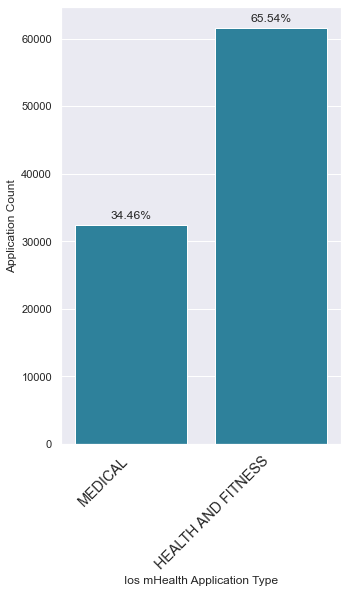

In [531]:
draw_count_plot_with_annot(df, 'App Type', 'Ios mHealth Application Type', 'Application Count', 
                           fig_size=(5,6), annotCount=False)

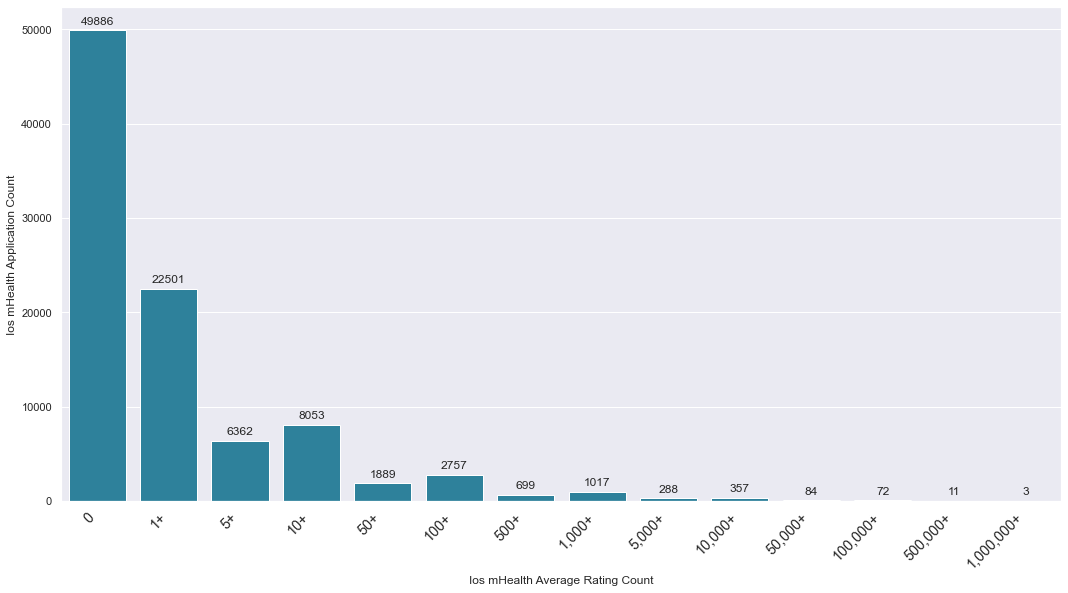

In [529]:
draw_count_plot_with_annot(df, 'Rating Count Range', 'Ios mHealth Average Rating Count',
                           'Ios mHealth Application Count',fig_size=(15,6),
                           annotCount=True, order=rating_count_range_order)

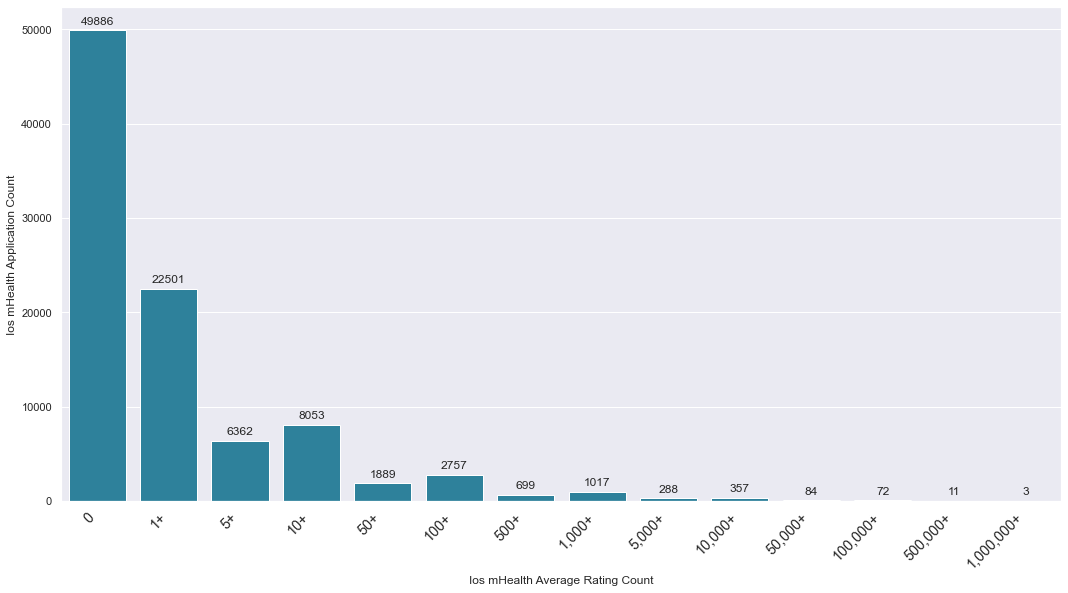

In [482]:
draw_count_plot_with_annot(df, 'Rating Count Range', 'Ios mHealth Average Rating Count',
                           'Ios mHealth Application Count',fig_size=(15,6),
                           annotCount=True, order=rating_count_range_order)

In [483]:
df.groupby(by=['Rating Count Range', 'App Type']).count()

Unnamed: 0  App Name   Size  \
Rating Count Range App Type                                          
0                  HEALTH AND FITNESS       32786     32786  32786   
                   MEDICAL                  17100     17100  17100   
1+                 HEALTH AND FITNESS       14244     14244  14244   
                   MEDICAL                   8257      8257   8257   
1,000+             HEALTH AND FITNESS         684       684    684   
                   MEDICAL                    333       333    333   
1,000,000+         HEALTH AND FITNESS           3         3      3   
10+                HEALTH AND FITNESS        5452      5452   5452   
                   MEDICAL                   2601      2601   2601   
10,000+            HEALTH AND FITNESS         233       233    233   
                   MEDICAL                    124       124    124   
100+               HEALTH AND FITNESS        1944      1944   1944   
                   MEDICAL                    813       813    813   
100,000+           HEALTH AND FITNESS          51        51     51   
                   MEDICAL                     21        21     21   
5+                 HEALTH AND FITNESS        4143      4143   4143   
                   MEDICAL                   2219      2219   2219   
5,000+             HEALTH AND FITNESS         199       199    199   
                   MEDICAL                     89        89     89   
50+                HEALTH AND FITNESS        1306      1306   1306   
                   MEDICAL                    583       583    583   
50,000+            HEALTH AND FITNESS          61        61     61   
                   MEDICAL                     23        23     23   
500+               HEALTH AND FITNESS         483       483    483   
                   MEDICAL                    216       216    216   
500,000+           HEALTH AND FITNESS           9         9      9   
                   MEDICAL                      2         2      2   

                                       Age Rating  Languages  Price  \
Rating Count Range App Type                                           
0                  HEALTH AND FITNESS       32786      32786  32786   
                   MEDICAL                  17100      17100  17100   
1+                 HEALTH AND FITNESS       14244      14244  14244   
                   MEDICAL                   8257       8257   8257   
1,000+             HEALTH AND FITNESS         684        684    684   
                   MEDICAL                    333        333    333   
1,000,000+         HEALTH AND FITNESS           3          3      3   
10+                HEALTH AND FITNESS        5452       5452   5452   
                   MEDICAL                   2601       2601   2601   
10,000+            HEALTH AND FITNESS         233        233    233   
                   MEDICAL                    124        124    124   
100+               HEALTH AND FITNESS        1944       1944   1944   
                   MEDICAL                    813        813    813   
100,000+           HEALTH AND FITNESS          51         51     51   
                   MEDICAL                     21         21     21   
5+                 HEALTH AND FITNESS        4143       4143   4143   
                   MEDICAL                   2219       2219   2219   
5,000+             HEALTH AND FITNESS         199        199    199   
                   MEDICAL                     89         89     89   
50+                HEALTH AND FITNESS        1306       1306   1306   
                   MEDICAL                    583        583    583   
50,000+            HEALTH AND FITNESS          61         61     61   
                   MEDICAL                     23         23     23   
500+               HEALTH AND FITNESS         483        483    483   
                   MEDICAL                    216        216    216   
500,000+           HEALTH AND FITNESS           9          9      9   
                   M

In [484]:
df['Rating Count'] == 0

0        False
1        False
2         True
3         True
4         True
         ...  
93974    False
93975     True
93976     True
93977     True
93978     True
Name: Rating Count, Length: 93979, dtype: bool

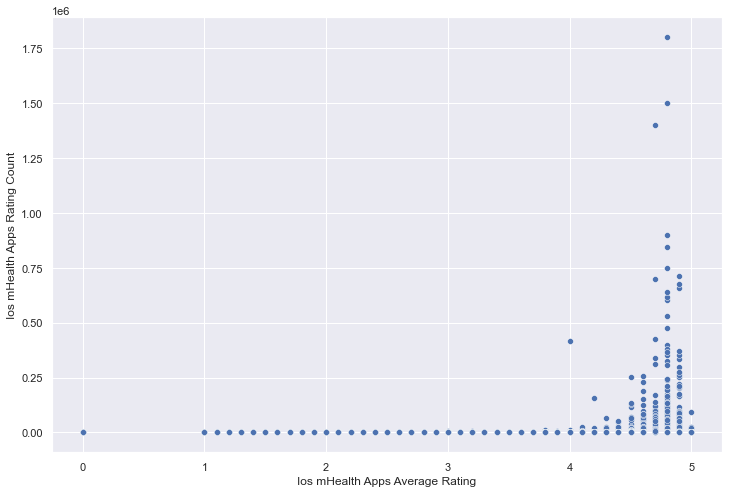

In [485]:
sbn.scatterplot(data=df, y='Rating Count', x='Average Rating')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)
pyplot.xlabel('Ios mHealth Apps Average Rating')
pyplot.ylabel('Ios mHealth Apps Rating Count')
pyplot.show()

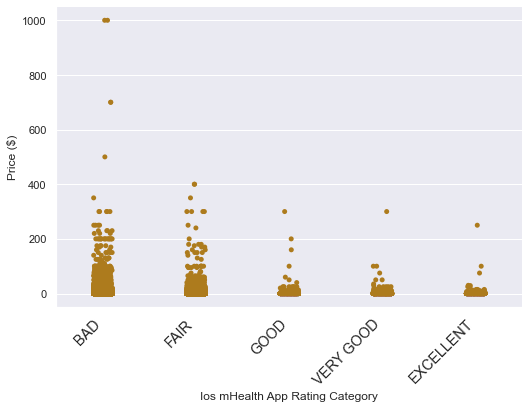

In [486]:
sbn.catplot(data=df, x='App Grade', y='Price',
            height=5, aspect=1.5, color="#AD7B1D", order=app_grade_order)
set_plot_labels('Ios mHealth App Rating Category', 'Price ($)', 'large')

In [487]:
df[df['Price']==df['Price'].max()]

,Unnamed: 0,App Name,Size,Age Rating,Languages,Price,InApp Purchase,Average Rating,Rating Count,Privacy Data,App Link,Number of Versions,Last Version Date,First Version Date,App Type,is_english_supported,Service Type,Rating Count Range,is_available_in_multiple_langs,is_privacy_data_collected,is_app_ever_updated,Price Category,is_updated_this_year,App Grade,age_rating_integer
80316,91169,VERT Stealth,155.5 MB,4+,English,999.99,False,0.0,0,"Contact Info,Identifiers,Diagnostics",https://apps.apple.com/us/app/vert-stealth/id1...,25,"Oct 25, 2021","Nov 22, 2019",HEALTH AND FITNESS,True,PAID,0,False,True,True,500+,False,BAD,4
80317,91170,VERT Team System,155.6 MB,4+,English,999.99,False,0.0,0,"Contact Info,Identifiers,Diagnostics",https://apps.apple.com/us/app/vert-team-system...,25,"Oct 25, 2021","Nov 22, 2019",HEALTH AND FITNESS,True,PAID,0,False,True,True,500+,False,BAD,4


In [488]:
df[df['App Grade']=='VERY GOOD']['Price'].max()

299.99

In [489]:
len(df)

93979

In [490]:
len(df['App Name'].unique())

93915

In [491]:
df[['InApp Purchase']].value_counts()

InApp Purchase
False             80946
True              13033
dtype: int64

In [492]:
13033/(13033+80946)

0.13867991785398864

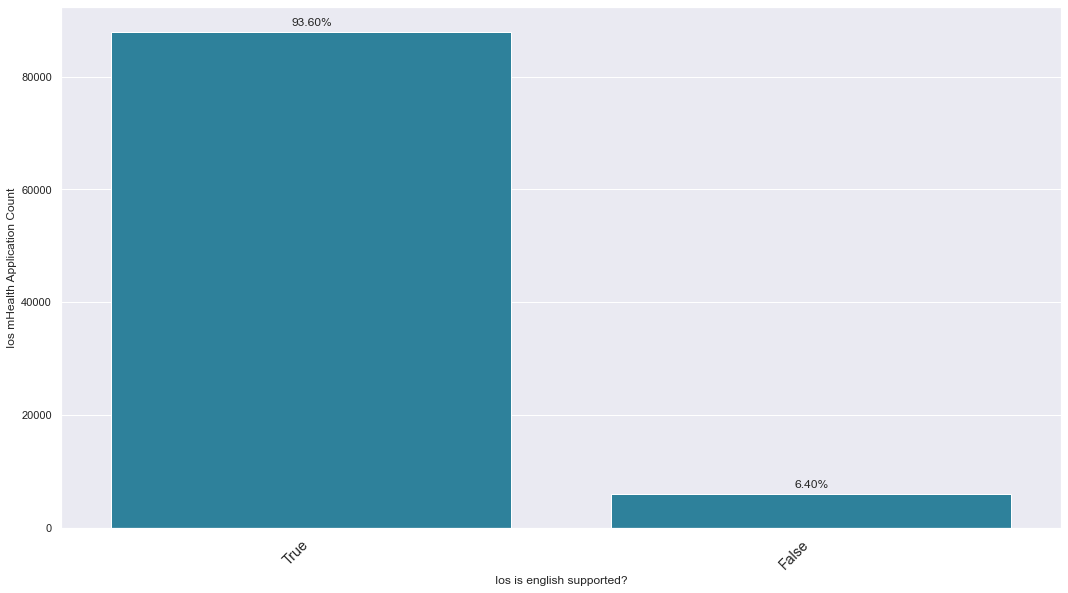

In [493]:
draw_count_plot_with_annot(df, 'is_english_supported', 'Ios is english supported?',
                           'Ios mHealth Application Count',fig_size=(15,6),
                           annotCount=False, order=[True, False])

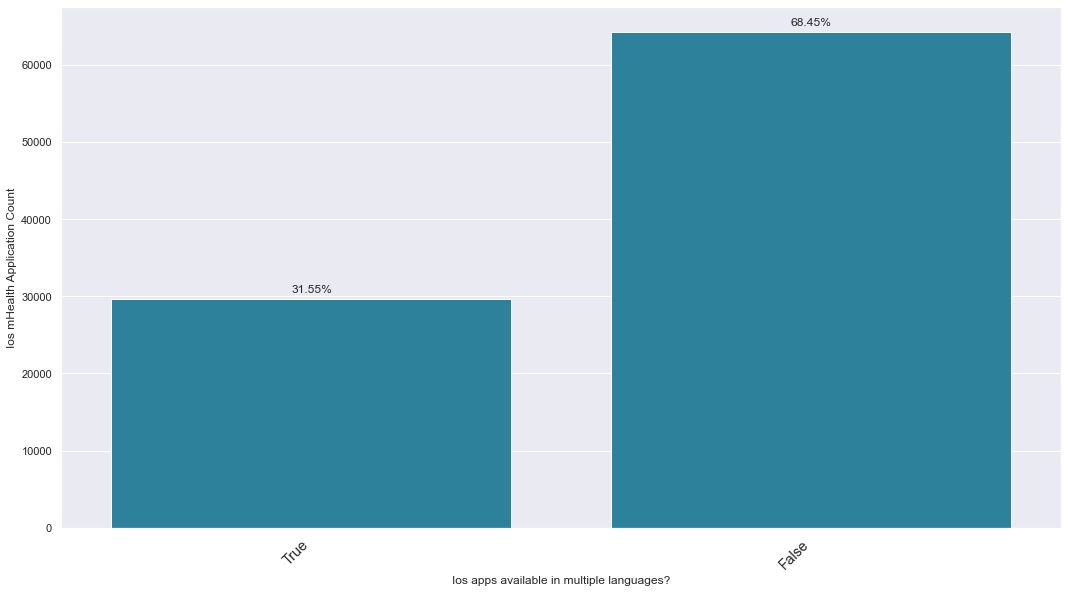

In [494]:
draw_count_plot_with_annot(df, 'is_available_in_multiple_langs', 'Ios apps available in multiple languages?',
                           'Ios mHealth Application Count',fig_size=(15,6),
                           annotCount=False, order=[True, False])

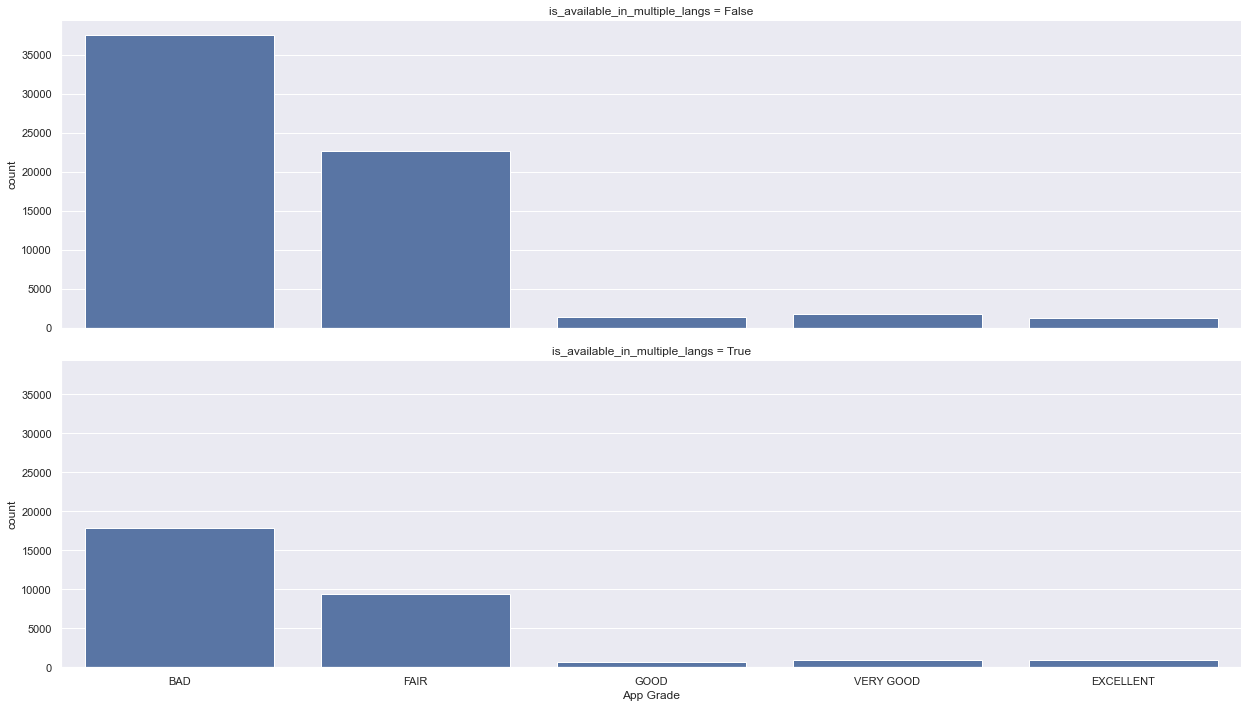

In [495]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="is_available_in_multiple_langs", col_wrap=1, height=5, aspect=3.5)
eng_supp_app_grade_plot.map(sbn.countplot, "App Grade", order=app_grade_order)

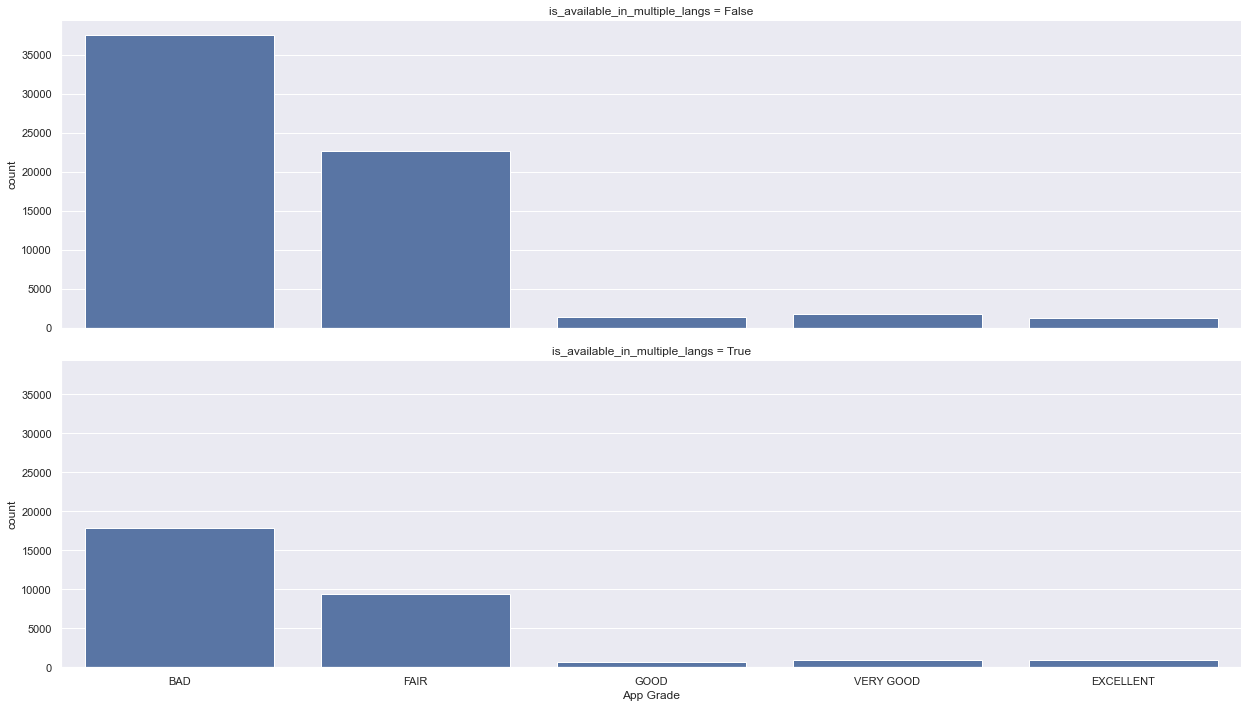

In [496]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="is_available_in_multiple_langs", col_wrap=1, height=5, aspect=3.5)
eng_supp_app_grade_plot.map(sbn.countplot, "App Grade", order=app_grade_order)

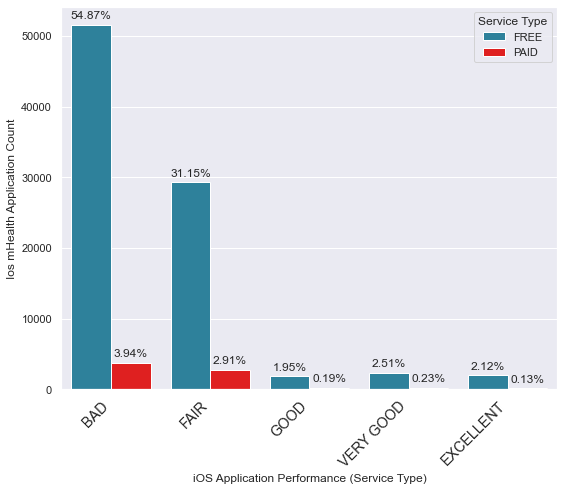

In [545]:
draw_count_plot_with_annot(df, 'App Grade', 'iOS Application Performance (Service Type)',
                           'Ios mHealth Application Count',hue= 'Service Type', fig_size=(8,5), order=app_grade_order,
                           annotCount=False, palette=['#1C8BAD', 'red'])

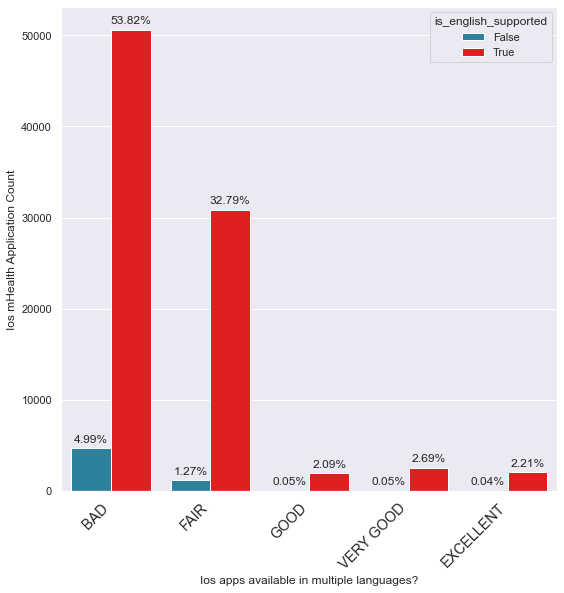

In [558]:
draw_count_plot_with_annot(df, 'App Grade', 'Ios apps available in multiple languages?',
                           'Ios mHealth Application Count',hue= 'is_english_supported', fig_size=(8,6),
                           order=app_grade_order,
                           annotCount=False, palette=['#1C8BAD', 'red'])

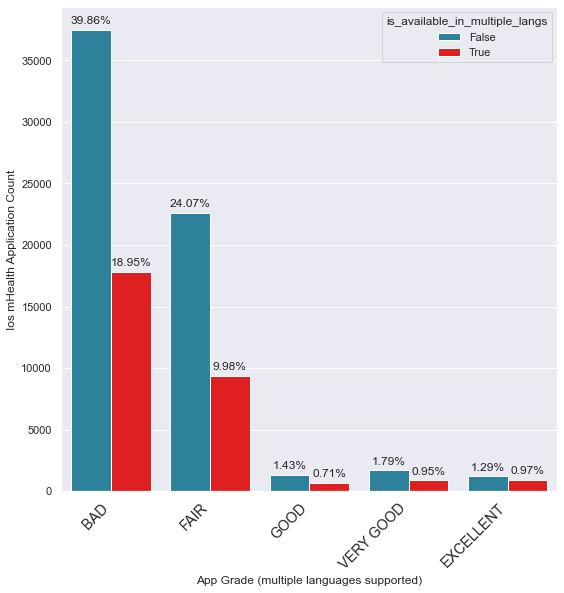

In [546]:
draw_count_plot_with_annot(df, 'App Grade', 'App Grade (multiple languages supported)',
                           'Ios mHealth Application Count',hue= 'is_available_in_multiple_langs', fig_size=(8,6), 
                           order=app_grade_order,
                           annotCount=False, palette=['#1C8BAD', 'red'])

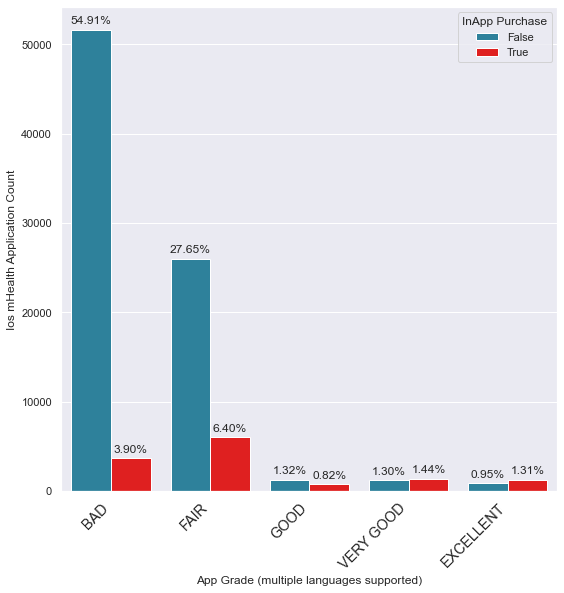

In [549]:
draw_count_plot_with_annot(df, 'App Grade', 'App Grade (multiple languages supported)',
                           'Ios mHealth Application Count',hue= 'InApp Purchase', fig_size=(8,6), 
                           order=app_grade_order,
                           annotCount=False, palette=['#1C8BAD', 'red'])

In [548]:
df['is_available_in_multiple_langs'].value_counts()

False    64330
True     29649
Name: is_available_in_multiple_langs, dtype: int64

In [ ]:
draw_count_plot_with_annot(df, 'App Grade', 'Ios apps available in multiple languages?',
                           'Ios mHealth Application Count',hue= 'Service Type', fig_size=(8,6),
                           annotCount=False)

In [550]:
df['InApp Purchase'].value_counts()

False    80946
True     13033
Name: InApp Purchase, dtype: int64

In [551]:
80946/(80946+13033)

0.8613200821460113

In [553]:
df[df['App Grade'].isin(['VERY GOOD', 'EXCELLENT'])]['InApp Purchase'].value_counts()

True     2578
False    2113
Name: InApp Purchase, dtype: int64

In [554]:
2578/(2578+2113)

0.5495629929652526

In [559]:
df[df['App Grade'].isin(['VERY GOOD', 'EXCELLENT'])]['is_english_supported'].value_counts()

True     4603
False      88
Name: is_english_supported, dtype: int64

In [561]:
4603/(88+4603)

0.981240673630356

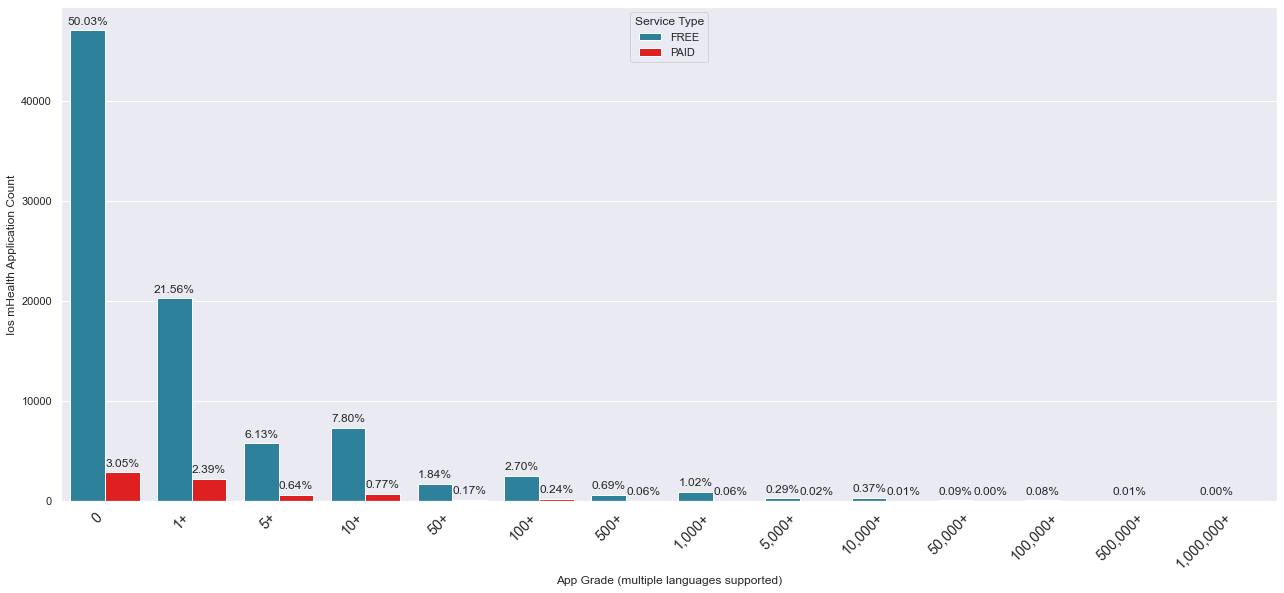

In [566]:
draw_count_plot_with_annot(df, 'Rating Count Range', 'App Grade (multiple languages supported)',
                           'Ios mHealth Application Count',hue= 'Service Type', fig_size=(18,6), 
                           
     order=rating_count_range_order, annotCount=False, palette=['#1C8BAD', 'red'])

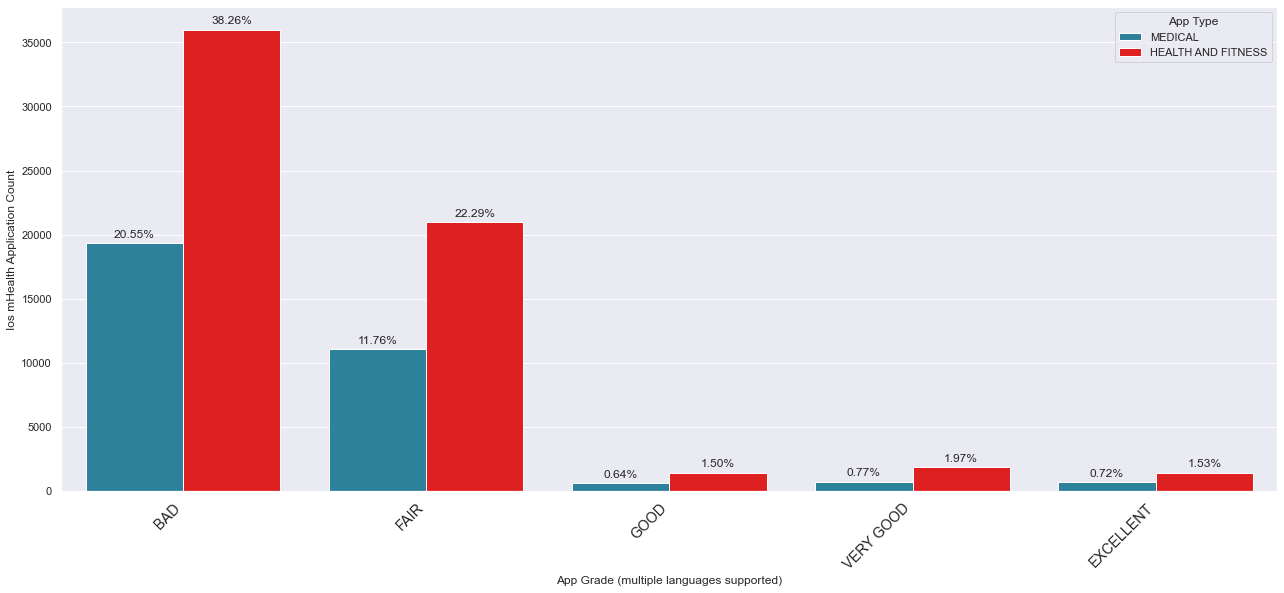

In [568]:
draw_count_plot_with_annot(df, 'App Grade', 'App Grade (multiple languages supported)',
                           'Ios mHealth Application Count',hue= 'App Type', fig_size=(18,6), 
                           
     order=app_grade_order, annotCount=False, palette=['#1C8BAD', 'red'])